# Backtesting with backtrader library
Notes:  
Timestamp must be in the exact format specified for datafeed   **Timestamp needs to be first column index**  
Params for datafeed need to be specified as tuple of tuples  
Within strategy data is accessed via self.datas[0] for ex: self.datas[0].high_delta[0] would get you the first timeperiod's high_delta  
The current data has already happened and cannot be used to execute an order (ex. you cannot look at the current close price and simultaneously buy the current close, the order will be executed at open instead), orders will be executed on the following day.

## Import Data and Run Backtest

In [2]:
import os
import sys
sys.path.append('../../scripts')
from backtesting_backtrader import *

ModuleNotFoundError: No module named 'backtesting_backtrader'

In [2]:
def capstone_data_prep(pred_folder_name, pred_col_name, ticker_df_filepath, starting_cash=100000, dirty_data=False):
    """Main loop, preps data and executes backtrader on all stocks in the prediction folder"""
    ticker_backtesting_dict = {}
    for pred_file in os.listdir(f'../../data/ticker_predictions/{pred_folder_name}'):
        # collect data
        ticker_name = pred_file.split('_')[0]
        pred_df = pd.read_csv(f'../../data/ticker_predictions/{pred_folder_name}/{pred_file}')
        ticker_df = pd.read_csv(ticker_df_filepath + f'/{ticker_name}_full_data.csv')
        
        # make timestamp in column position 0, SPECIFIC TO FULL DATA IN FILE 
        ticker_df = ticker_df.rename({'reportperiod':'timestamp'}, axis=1)
        ticker_cols = list(ticker_df.columns)
        ticker_cols[5] = 'ts_cpy'
        ticker_cols[0] = 'timestamp'
        ticker_df.columns = ticker_cols
        ticker_df['timestamp'] = ticker_df['ts_cpy']
        # hack
        if dirty_data == False:
            pred_df['timestamp'] = pd.to_datetime(pred_df['timestamp'])
            ticker_df['timestamp'] = pd.to_datetime(ticker_df['timestamp'])
        # merge prediction data with full data, on key = timestamp
        ticker_df = ticker_df.merge(pred_df.loc[:, ['timestamp', pred_col_name]], on='timestamp')
        # new prediction column name = "prediction", important because backtester strategy looks for this column name
        ticker_df = ticker_df.rename({pred_col_name:'prediction'}, axis=1)
        # remove all non-prediction rows in prediction field
        ticker_df = ticker_df[ticker_df.prediction > 0]
        # skip nonfeatures, keep timestamp, SPECIFIC TO FULL DATA IN FILE 
        nonfeatures = ticker_df.columns[1:7]
        features = [col for col in ticker_df.columns if col not in nonfeatures]
        # get index of start and end dates for trading
        ticker_df = ticker_df[features]
        ticker_df.columns = [c.lower() for c in ticker_df.columns]
        idx1 = ticker_df.prediction[ticker_df.prediction > 0].index[0]
        idx2 = ticker_df.prediction[ticker_df.prediction > 0].index[-1]
        start_date = pred_df.timestamp[idx1]
        end_date  = pred_df.timestamp[idx2]
        
        # Prepare data for backtrader
        prep_data = prepare_data(ticker_df.copy(), start_date, end_date, 'temp/prep_data.csv')
        class DataFeed(bt.feeds.GenericCSVData):
            lines = tuple(prep_data[2])
            params = prep_data[1]
        
        print(f"--------Ticker Name-------: {ticker_name}")
        strategies = [BuyAndHold, BasicStrategy]
        ticker_backtesting_dict[ticker_name] = {BuyAndHold.__name__:{},
                                                BasicStrategy.__name__:{}}
        for i in range(len(strategies)):
            # initialize everything and run strategy
            cerebro = bt.Cerebro(cheat_on_open=True)
            cerebro.broker.setcash(starting_cash)
            data = DataFeed(dataname=prep_data[0])
            cerebro.adddata(data)
            cerebro.addstrategy(strategies[i])
            cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Months, riskfreerate=0, _name = 'sharpe')
            cerebro.addanalyzer(bt.analyzers.DrawDown, _name = 'dd')
            back = cerebro.run()
            total_return = cerebro.broker.getvalue() / starting_cash - 1
            
            ticker_backtesting_dict[ticker_name][strategies[i].__name__] = {'total_return': total_return, 
                                                                         'monthly_sharpe': back[0].analyzers.sharpe.get_analysis(),
                                                                         'drawdown': back[0].analyzers.dd.get_analysis(),
                                                                         'cerebro_object': cerebro
                                                                        }
                                                     
        
    return ticker_backtesting_dict

### XGBoost Results

In [3]:
xgb_backtesting_dict = capstone_data_prep('xgboost_preds', 'holdout_preds', '../../data/ticker_data', dirty_data=True)

avg_analysis_dict_xgb = {'BuyAndHold':
                     {'return_avg':[], 'sharpe_avg':[], 'max_drawdown_avg':[]},
                     'BasicStrategy':
                     {'return_avg':[], 'sharpe_avg':[], 'max_drawdown_avg':[]} }
# get values
for ticker, ticker_dict in xgb_backtesting_dict.items():
    for strat_name in ['BuyAndHold', 'BasicStrategy']:
        for analysis_type, value in ticker_dict[strat_name].items():
            if analysis_type == 'drawdown':
                 avg_analysis_dict_xgb[strat_name]['max_drawdown_avg'].append(value['max']['drawdown'])
            elif analysis_type == 'monthly_sharpe':
                avg_analysis_dict_xgb[strat_name]['sharpe_avg'].append(value['sharperatio'])
            elif analysis_type == 'total_return':
                avg_analysis_dict_xgb[strat_name]['return_avg'].append(value)

# calculate averages
for strat, val_dict in avg_analysis_dict_xgb.items():
    for val_type, val_list in avg_analysis_dict_xgb[strat].items():
        el_sum = 0
        for el in val_list:
            el_sum+=el
        avg_analysis_dict_xgb[strat][val_type] = el_sum / len(val_list)

--------Ticker Name-------: ADSK
2019-09-19, BUY EXECUTED, 151.39
Stop price: 329.07000732421875
ROI:        117.27%
***The limit sells for this strategy are valid for 1 day***
2019-09-18, Current Portfolio Value : 100000.0
2019-09-18, MARKET BUY CREATE 660 shares at next open, current close price: 151.11000061035156
2019-09-19, BUY EXECUTED, 151.39
2019-09-19, Current Portfolio Value : 101313.40362548828
2019-09-19, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2019-09-20, SELL EXECUTED, 153.14
2019-09-20, Current Portfolio Value : 101155.0
2019-09-20, MARKET BUY CREATE 663 shares at next open, current close price: 153.33999633789062
2019-09-23, BUY EXECUTED, 152.46
2019-09-23, Current Portfolio Value : 101095.32231140137
2019-09-23, LIMIT SELL CREATE 663 shares at 155.39136422503358
2019-09-24, Current Portfolio Value : 98947.20878601074
2019-09-24, LIMIT SELL CREATE 663 shares at 154.40838642025483
2019-09-25, Current Portfolio Value : 97820.10069274902
2019-09-25, LIMIT SELL CREAT

2020-08-19, BUY EXECUTED, 244.40
2020-08-19, Current Portfolio Value : 230078.9561199773
2020-08-19, LIMIT SELL CREATE 953 shares at 245.9131653883451
2020-08-20, SELL EXECUTED, 245.91
2020-08-20, Current Portfolio Value : 234360.9444800653
2020-08-20, MARKET BUY CREATE 939 shares at next open, current close price: 249.1499938964844
2020-08-21, BUY EXECUTED, 249.33
2020-08-21, Current Portfolio Value : 233365.60677254573
2020-08-21, LIMIT SELL CREATE 939 shares at 252.4164794896533
2020-08-24, Current Portfolio Value : 236680.27562630552
2020-08-24, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2020-08-25, SELL EXECUTED, 249.02
2020-08-25, Current Portfolio Value : 234069.85677254573
2020-08-25, MARKET BUY CREATE 948 shares at next open, current close price: 252.2400054931641
2020-08-26, BUY EXECUTED, 246.66
2020-08-26, Current Portfolio Value : 235539.25966561213
2020-08-26, LIMIT SELL CREATE 948 shares at 255.54700274039902
2020-08-27, Current Portfolio Value : 230704.45387947935
20

2021-07-09, Current Portfolio Value : 255489.00207130195
2021-07-09, LIMIT SELL CREATE 864 shares at 298.4093928905713
2021-07-12, Current Portfolio Value : 252508.19152442695
2021-07-12, LIMIT SELL CREATE 864 shares at 299.33157049512374
2021-07-13, Current Portfolio Value : 256387.56945411445
2021-07-13, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2021-07-14, SELL EXECUTED, 298.50
2021-07-14, Current Portfolio Value : 258184.67785255195
2021-07-14, MARKET BUY CREATE 867 shares at next open, current close price: 297.1000061035156
2021-07-15, BUY EXECUTED, 297.48
2021-07-15, Current Portfolio Value : 255852.44573585273
2021-07-15, LIMIT SELL CREATE 867 shares at 301.01756022872
2021-07-16, Current Portfolio Value : 254586.60668555976
2021-07-16, LIMIT SELL CREATE 867 shares at 298.7336812423382
2021-07-19, Current Portfolio Value : 249367.27621070624
2021-07-19, LIMIT SELL CREATE 867 shares at 297.25412723459164
2021-07-20, SELL EXECUTED, 297.25
2021-07-20, Current Portfolio Value :

--------Ticker Name-------: HD
2019-09-19, BUY EXECUTED, 231.15
Stop price: 368.5899963378906
ROI:        59.37%
***The limit sells for this strategy are valid for 1 day***
2019-09-18, Current Portfolio Value : 100000.0
2019-09-18, MARKET BUY CREATE 432 shares at next open, current close price: 230.8300018310547
2019-09-19, BUY EXECUTED, 231.15
2019-09-19, Current Portfolio Value : 98691.04052734374
2019-09-19, LIMIT SELL CREATE 432 shares at 232.73308312018344
2019-09-20, Current Portfolio Value : 97200.64184570311
2019-09-20, LIMIT SELL CREATE 432 shares at 230.00073371676262
2019-09-23, Current Portfolio Value : 97883.20263671874
2019-09-23, LIMIT SELL CREATE 432 shares at 226.52229321877533
2019-09-24, SELL EXECUTED, 228.14
2019-09-24, Current Portfolio Value : 98699.68237304686
2019-09-24, MARKET BUY CREATE 435 shares at next open, current close price: 225.41000366210938
2019-09-25, BUY EXECUTED, 226.59
2019-09-25, Current Portfolio Value : 99356.53662109372
2019-09-25, MARKET SEL

2020-08-25, BUY EXECUTED, 287.27
2020-08-25, Current Portfolio Value : 171415.72487151902
2020-08-25, LIMIT SELL CREATE 599 shares at 289.114114522934
2020-08-26, SELL EXECUTED, 289.11
2020-08-26, Current Portfolio Value : 173203.2065459518
2020-08-26, MARKET BUY CREATE 592 shares at next open, current close price: 291.92999267578125
2020-08-27, BUY EXECUTED, 292.22
2020-08-27, Current Portfolio Value : 171077.92871392056
2020-08-27, LIMIT SELL CREATE 592 shares at 294.336813723261
2020-08-28, Current Portfolio Value : 169692.6508818893
2020-08-28, LIMIT SELL CREATE 592 shares at 291.00961913319765
2020-08-31, Current Portfolio Value : 168952.6508818893
2020-08-31, LIMIT SELL CREATE 592 shares at 288.6503306616505
2020-09-01, Current Portfolio Value : 169485.44726860806
2020-09-01, LIMIT SELL CREATE 592 shares at 287.3900250185688
2020-09-02, SELL EXECUTED, 287.39
2020-09-02, Current Portfolio Value : 170343.86063428828
2020-09-02, MARKET BUY CREATE 592 shares at next open, current clo

2021-07-02, BUY EXECUTED, 322.53
2021-07-02, Current Portfolio Value : 170098.26835713178
2021-07-02, LIMIT SELL CREATE 527 shares at 324.1909497965535
2021-07-06, Current Portfolio Value : 168285.38707051068
2021-07-06, LIMIT SELL CREATE 527 shares at 325.36051712563494
2021-07-07, Current Portfolio Value : 170509.32771382123
2021-07-07, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2021-07-08, SELL EXECUTED, 319.07
2021-07-08, Current Portfolio Value : 168185.2557838896
2021-07-08, MARKET BUY CREATE 524 shares at next open, current close price: 318.5400085449219
2021-07-09, BUY EXECUTED, 320.54
2021-07-09, Current Portfolio Value : 168997.4493874052
2021-07-09, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2021-07-12, SELL EXECUTED, 321.07
2021-07-12, Current Portfolio Value : 168462.97514424115
2021-07-12, MARKET BUY CREATE 522 shares at next open, current close price: 321.739990234375
2021-07-13, BUY EXECUTED, 322.44
2021-07-13, Current Portfolio Value : 165649.38749775678
2021-0

--------Ticker Name-------: MSFT
2019-09-17, BUY EXECUTED, 136.96
Stop price: 336.989990234375
ROI:        146.02%
***The limit sells for this strategy are valid for 1 day***
2019-09-16, Current Portfolio Value : 100000.0
2019-09-16, MARKET BUY CREATE 730 shares at next open, current close price: 136.33000183105472
2019-09-17, BUY EXECUTED, 136.96
2019-09-17, Current Portfolio Value : 100313.8946533203
2019-09-17, LIMIT SELL CREATE 730 shares at 137.58915899775823
2019-09-18, SELL EXECUTED, 137.59
2019-09-18, Current Portfolio Value : 100459.28116724045
2019-09-18, MARKET BUY CREATE 716 shares at next open, current close price: 138.52000427246094
2019-09-19, BUY EXECUTED, 140.30
2019-09-19, Current Portfolio Value : 101010.6042263225
2019-09-19, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2019-09-20, SELL EXECUTED, 141.01
2019-09-20, Current Portfolio Value : 100967.6350490764
2019-09-20, MARKET BUY CREATE 725 shares at next open, current close price: 139.44000244140622
2019-09-23, 

2020-08-13, Current Portfolio Value : 192161.80033249393
2020-08-13, LIMIT SELL CREATE 920 shares at 211.69256943523945
2020-08-14, Current Portfolio Value : 192345.79752487678
2020-08-14, LIMIT SELL CREATE 920 shares at 211.2805689791985
2020-08-17, Current Portfolio Value : 193615.40201706425
2020-08-17, LIMIT SELL CREATE 920 shares at 211.43806439375115
2020-08-18, SELL EXECUTED, 211.44
2020-08-18, Current Portfolio Value : 194680.82238236218
2020-08-18, MARKET BUY CREATE 920 shares at next open, current close price: 211.4900054931641
2020-08-19, BUY EXECUTED, 211.49
2020-08-19, Current Portfolio Value : 193034.01452103403
2020-08-19, LIMIT SELL CREATE 920 shares at 213.9561511704124
2020-08-20, SELL EXECUTED, 213.96
2020-08-20, Current Portfolio Value : 196949.67640543063
2020-08-20, MARKET BUY CREATE 920 shares at next open, current close price: 214.5800018310547
2020-08-21, BUY EXECUTED, 213.86
2020-08-21, Current Portfolio Value : 196176.8797745712
2020-08-21, LIMIT SELL CREATE 

2021-06-10, Current Portfolio Value : 213767.09304342183
2021-06-10, MARKET BUY CREATE 828 shares at next open, current close price: 257.239990234375
2021-06-11, BUY EXECUTED, 257.99
2021-06-11, Current Portfolio Value : 213684.31325826558
2021-06-11, LIMIT SELL CREATE 828 shares at 259.4854945570114
2021-06-14, Current Portfolio Value : 215340.31325826558
2021-06-14, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2021-06-15, SELL EXECUTED, 259.77
2021-06-15, Current Portfolio Value : 215240.9320326797
2021-06-15, MARKET BUY CREATE 829 shares at next open, current close price: 258.3599853515625
2021-06-16, BUY EXECUTED, 259.40
2021-06-16, Current Portfolio Value : 213566.36114034566
2021-06-16, LIMIT SELL CREATE 829 shares at 260.35150448951754
2021-06-17, SELL EXECUTED, 260.35
2021-06-17, Current Portfolio Value : 216029.73431430414
2021-06-17, MARKET BUY CREATE 832 shares at next open, current close price: 260.89999389648443
2021-06-18, BUY EXECUTED, 259.63
2021-06-18, Current Portfo

--------Ticker Name-------: UNH
2019-09-17, BUY EXECUTED, 233.07
Stop price: 462.6199951171875
ROI:        98.48%
***The limit sells for this strategy are valid for 1 day***
2019-09-16, Current Portfolio Value : 100000.0
2019-09-16, MARKET BUY CREATE 429 shares at next open, current close price: 234.42999267578125
2019-09-17, BUY EXECUTED, 233.07
2019-09-17, Current Portfolio Value : 99764.04869079588
2019-09-17, LIMIT SELL CREATE 429 shares at 237.0148515394394
2019-09-18, Current Portfolio Value : 98944.65711975099
2019-09-18, LIMIT SELL CREATE 429 shares at 235.1436753850466
2019-09-19, Current Portfolio Value : 99905.61947631834
2019-09-19, LIMIT SELL CREATE 429 shares at 233.25332872732727
2019-09-20, SELL EXECUTED, 234.77
2019-09-20, Current Portfolio Value : 100729.29869079588
2019-09-20, MARKET BUY CREATE 438 shares at next open, current close price: 232.88999938964844
2019-09-23, BUY EXECUTED, 229.77
2019-09-23, Current Portfolio Value : 100291.29869079588
2019-09-23, LIMIT SE

2020-08-05, BUY EXECUTED, 306.83
2020-08-05, Current Portfolio Value : 139712.1846029021
2020-08-05, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2020-08-06, SELL EXECUTED, 312.00
2020-08-06, Current Portfolio Value : 139502.0940572478
2020-08-06, MARKET BUY CREATE 445 shares at next open, current close price: 314.05999755859375
2020-08-07, BUY EXECUTED, 313.34
2020-08-07, Current Portfolio Value : 141144.14514367358
2020-08-07, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2020-08-10, SELL EXECUTED, 317.00
2020-08-10, Current Portfolio Value : 141130.79568688647
2020-08-10, MARKET BUY CREATE 437 shares at next open, current close price: 319.1000061035156
2020-08-11, BUY EXECUTED, 322.92
2020-08-11, Current Portfolio Value : 137910.0944844939
2020-08-11, LIMIT SELL CREATE 437 shares at 322.02327981818235
2020-08-12, SELL EXECUTED, 322.02
2020-08-12, Current Portfolio Value : 140738.92309951223
2020-08-12, MARKET BUY CREATE 438 shares at next open, current close price: 322.2699890136

2021-06-21, Current Portfolio Value : 161801.22844504437
2021-06-21, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2021-06-22, SELL EXECUTED, 400.61
2021-06-22, Current Portfolio Value : 162832.4595241459
2021-06-22, MARKET BUY CREATE 409 shares at next open, current close price: 398.6900024414063
2021-06-23, BUY EXECUTED, 397.82
2021-06-23, Current Portfolio Value : 161908.11553000525
2021-06-23, LIMIT SELL CREATE 409 shares at 403.9756365479844
2021-06-24, Current Portfolio Value : 163261.9045314701
2021-06-24, LIMIT SELL CREATE 409 shares at 400.8018722019915
2021-06-25, SELL EXECUTED, 400.80
2021-06-25, Current Portfolio Value : 164052.04225915493
2021-06-25, MARKET BUY CREATE 405 shares at next open, current close price: 404.95001220703125
2021-06-28, BUY EXECUTED, 404.95
2021-06-28, Current Portfolio Value : 162638.5838546139
2021-06-28, LIMIT SELL CREATE 405 shares at 409.2311261752329
2021-06-29, Current Portfolio Value : 161277.7897872311
2021-06-29, LIMIT SELL CREATE 405 sha

--------Ticker Name-------: WAT
2019-09-17, BUY EXECUTED, 231.57
Stop price: 349.9200134277344
ROI:        51.01%
***The limit sells for this strategy are valid for 1 day***
2019-09-16, Current Portfolio Value : 100000.0
2019-09-16, MARKET BUY CREATE 431 shares at next open, current close price: 231.5200042724609
2019-09-17, BUY EXECUTED, 231.57
2019-09-17, Current Portfolio Value : 98758.71789550781
2019-09-17, LIMIT SELL CREATE 431 shares at 233.74569746310038
2019-09-18, Current Portfolio Value : 98607.86526489258
2019-09-18, LIMIT SELL CREATE 431 shares at 230.8884897073367
2019-09-19, Current Portfolio Value : 98763.0255279541
2019-09-19, LIMIT SELL CREATE 431 shares at 230.53511885698757
2019-09-20, SELL EXECUTED, 230.54
2019-09-20, Current Portfolio Value : 99553.96307062336
2019-09-20, MARKET BUY CREATE 436 shares at next open, current close price: 228.6999969482422
2019-09-23, BUY EXECUTED, 227.86
2019-09-23, Current Portfolio Value : 99523.43987726397
2019-09-23, LIMIT SELL C

2020-07-29, BUY EXECUTED, 224.19
2020-07-29, Current Portfolio Value : 98211.59438776644
2020-07-29, LIMIT SELL CREATE 453 shares at 225.6385031357986
2020-07-30, Current Portfolio Value : 96508.30996393834
2020-07-30, LIMIT SELL CREATE 453 shares at 218.60149654204173
2020-07-31, Current Portfolio Value : 96684.97968744909
2020-07-31, LIMIT SELL CREATE 453 shares at 214.805340318324
2020-08-03, Current Portfolio Value : 96639.68383478794
2020-08-03, LIMIT SELL CREATE 453 shares at 215.1990889260524
2020-08-04, Current Portfolio Value : 95303.33521723421
2020-08-04, LIMIT SELL CREATE 453 shares at 215.0981368298653
2020-08-05, Current Portfolio Value : 95792.56913447056
2020-08-05, LIMIT SELL CREATE 453 shares at 212.11978039648602
2020-08-06, SELL EXECUTED, 212.12
2020-08-06, Current Portfolio Value : 96218.29297194982
2020-08-06, MARKET BUY CREATE 456 shares at next open, current close price: 210.63999938964844
2020-08-07, BUY EXECUTED, 210.64
2020-08-07, Current Portfolio Value : 96

2021-06-16, BUY EXECUTED, 342.11
2021-06-16, Current Portfolio Value : 152330.24934155404
2021-06-16, LIMIT SELL CREATE 444 shares at 345.0858459968076
2021-06-17, SELL EXECUTED, 345.09
2021-06-17, Current Portfolio Value : 153225.2817121835
2021-06-17, MARKET BUY CREATE 444 shares at next open, current close price: 346.55999755859375
2021-06-18, BUY EXECUTED, 345.04
2021-06-18, Current Portfolio Value : 152190.75412429287
2021-06-18, LIMIT SELL CREATE 444 shares at 349.8916156152627
2021-06-21, Current Portfolio Value : 152070.87900222256
2021-06-21, LIMIT SELL CREATE 444 shares at 346.0354019611441
2021-06-22, Current Portfolio Value : 153482.79575026943
2021-06-22, LIMIT SELL CREATE 444 shares at 345.73201335869817
2021-06-23, SELL EXECUTED, 346.19
2021-06-23, Current Portfolio Value : 153735.87900222256
2021-06-23, MARKET BUY CREATE 441 shares at next open, current close price: 346.95001220703125
2021-06-24, BUY EXECUTED, 348.08
2021-06-24, Current Portfolio Value : 152192.37900222

--------Ticker Name-------: XOM
2019-09-17, BUY EXECUTED, 73.82
Stop price: 65.72000122070311
ROI:        -10.97%
***The limit sells for this strategy are valid for 1 day***
2019-09-16, Current Portfolio Value : 100000.0
2019-09-16, MARKET BUY CREATE 1354 shares at next open, current close price: 73.7300033569336
2019-09-17, BUY EXECUTED, 73.82
2019-09-17, Current Portfolio Value : 99119.89793395996
2019-09-17, LIMIT SELL CREATE 1354 shares at 74.29306357801579
2019-09-18, Current Portfolio Value : 98646.0
2019-09-18, LIMIT SELL CREATE 1354 shares at 73.72878175052392
2019-09-19, Current Portfolio Value : 97982.54289245605
2019-09-19, LIMIT SELL CREATE 1354 shares at 73.37611041312813
2019-09-20, Current Portfolio Value : 97644.04289245605
2019-09-20, LIMIT SELL CREATE 1354 shares at 72.88237054077398
2019-09-23, Current Portfolio Value : 97711.73669433594
2019-09-23, LIMIT SELL CREATE 1354 shares at 72.63046134439719
2019-09-24, Current Portfolio Value : 96371.27958679199
2019-09-24, 

2020-08-05, BUY EXECUTED, 44.15
2020-08-05, Current Portfolio Value : 78692.60024330516
2020-08-05, LIMIT SELL CREATE 1794 shares at 43.86431727443779
2020-08-06, SELL EXECUTED, 43.86
2020-08-06, Current Portfolio Value : 78718.2881710733
2020-08-06, MARKET BUY CREATE 1820 shares at next open, current close price: 43.63999938964844
2020-08-07, BUY EXECUTED, 43.23
2020-08-07, Current Portfolio Value : 79100.48650481353
2020-08-07, LIMIT SELL CREATE 1820 shares at 44.03585749549347
2020-08-10, Current Portfolio Value : 81047.88594939362
2020-08-10, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2020-08-11, SELL EXECUTED, 45.50
2020-08-11, Current Portfolio Value : 82849.68900420319
2020-08-11, MARKET BUY CREATE 1863 shares at next open, current close price: 44.97000122070313
2020-08-12, BUY EXECUTED, 44.46
2020-08-12, Current Portfolio Value : 82160.38099410187
2020-08-12, LIMIT SELL CREATE 1863 shares at 45.37202683705619
2020-08-13, Current Portfolio Value : 80148.33758284699
2020-08-1

2021-06-16, LIMIT SELL CREATE 1916 shares at 64.93105418127925
2021-06-17, Current Portfolio Value : 118778.51212020352
2021-06-17, LIMIT SELL CREATE 1916 shares at 64.75391931169271
2021-06-18, Current Portfolio Value : 115732.07182784511
2021-06-18, LIMIT SELL CREATE 1916 shares at 62.7446242572546
2021-06-21, Current Portfolio Value : 119928.10919661954
2021-06-21, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2021-06-22, SELL EXECUTED, 62.85
2021-06-22, Current Portfolio Value : 120426.26598067716
2021-06-22, MARKET BUY CREATE 1880 shares at next open, current close price: 63.790000915527344
2021-06-23, BUY EXECUTED, 64.05
2021-06-23, Current Portfolio Value : 120821.06425948575
2021-06-23, LIMIT SELL CREATE 1880 shares at 64.43288877694613
2021-06-24, SELL EXECUTED, 64.43
2021-06-24, Current Portfolio Value : 121146.09114403119
2021-06-24, MARKET BUY CREATE 1875 shares at next open, current close price: 64.51999664306639
2021-06-25, BUY EXECUTED, 64.61
2021-06-25, Current Portfol

### Baseline results

In [4]:
baseline_results_avg = {}
baseline_results_full = {}
for f_name in ['ar_preds', 'arima_preds', 'linreg_preds', 'rfreg_preds']:
    print(f'----------{f_name}-----------')
    baseline_results_full[f_name] = capstone_data_prep(f_name, 'prediction', '../../data/ticker_data')
    avg_analysis_dict = {'BuyAndHold':
                     {'return_avg':[], 'sharpe_avg':[], 'max_drawdown_avg':[]},
                     'BasicStrategy':
                     {'return_avg':[], 'sharpe_avg':[], 'max_drawdown_avg':[]} }
    # get values
    for ticker, ticker_dict in baseline_results_full[f_name].items():
        for strat_name in ['BuyAndHold', 'BasicStrategy']:
            for analysis_type, value in ticker_dict[strat_name].items():
                if analysis_type == 'drawdown':
                     avg_analysis_dict[strat_name]['max_drawdown_avg'].append(value['max']['drawdown'])
                elif analysis_type == 'monthly_sharpe':
                    avg_analysis_dict[strat_name]['sharpe_avg'].append(value['sharperatio'])
                elif analysis_type == 'total_return':
                    avg_analysis_dict[strat_name]['return_avg'].append(value)

    # calculate averages
    for strat, val_dict in avg_analysis_dict.items():
        for val_type, val_list in avg_analysis_dict[strat].items():
            el_sum = 0
            for el in val_list:
                el_sum+=el
            avg_analysis_dict[strat][val_type] = el_sum / len(val_list)
    
    baseline_results_avg[f_name] = avg_analysis_dict

----------ar_preds-----------
--------Ticker Name-------: ADSK
2019-09-20, BUY EXECUTED, 153.14
Stop price: 329.07000732421875
ROI:        114.71%
***The limit sells for this strategy are valid for 1 day***
2019-09-19, Current Portfolio Value : 100000.0
2019-09-19, MARKET BUY CREATE 652 shares at next open, current close price: 153.3800048828125
2019-09-20, BUY EXECUTED, 153.14
2019-09-20, Current Portfolio Value : 100130.3980102539
2019-09-20, LIMIT SELL CREATE 652 shares at 155.29090367877183
2019-09-23, Current Portfolio Value : 99497.95721435547
2019-09-23, LIMIT SELL CREATE 652 shares at 154.30854587438162
2019-09-24, Current Portfolio Value : 97385.48358154297
2019-09-24, LIMIT SELL CREATE 652 shares at 151.02733424421638
2019-09-25, Current Portfolio Value : 96277.0756225586
2019-09-25, LIMIT SELL CREATE 652 shares at 149.30569337017928
2019-09-26, SELL EXECUTED, 149.31
2019-09-26, Current Portfolio Value : 97500.03247530611
2019-09-26, MARKET BUY CREATE 652 shares at next open,

2020-07-31, Current Portfolio Value : 152144.69730600566
2020-07-31, LIMIT SELL CREATE 643 shares at 239.4380095208472
2020-08-03, Current Portfolio Value : 154105.8492682859
2020-08-03, LIMIT SELL CREATE 643 shares at 242.52681670423547
2020-08-04, Current Portfolio Value : 154375.9080909178
2020-08-04, LIMIT SELL CREATE 643 shares at 242.9521583643039
2020-08-05, SELL EXECUTED, 242.95
2020-08-05, Current Portfolio Value : 156338.4498437257
2020-08-05, MARKET BUY CREATE 641 shares at next open, current close price: 243.1999969482422
2020-08-06, BUY EXECUTED, 243.64
2020-08-06, Current Portfolio Value : 156293.58492978528
2020-08-06, LIMIT SELL CREATE 641 shares at 246.66886410077328
2020-08-07, Current Portfolio Value : 151595.05375607926
2020-08-07, LIMIT SELL CREATE 641 shares at 239.24560519715922
2020-08-10, Current Portfolio Value : 148800.29336484388
2020-08-10, LIMIT SELL CREATE 641 shares at 234.83013381031262
2020-08-11, Current Portfolio Value : 146819.5959313722
2020-08-11,

2021-02-24, MARKET BUY CREATE 490 shares at next open, current close price: 298.9100036621094
2021-02-25, BUY EXECUTED, 294.81
2021-02-25, Current Portfolio Value : 139354.5351040179
2021-02-25, LIMIT SELL CREATE 490 shares at 287.64361400282644
2021-02-26, SELL EXECUTED, 287.64
2021-02-26, Current Portfolio Value : 141125.2065635474
2021-02-26, MARKET BUY CREATE 504 shares at next open, current close price: 276.0
2021-03-01, BUY EXECUTED, 279.86
2021-03-01, Current Portfolio Value : 143347.84840925052
2021-03-01, LIMIT SELL CREATE 504 shares at 287.8866575497676
2021-03-02, Current Portfolio Value : 140147.46071393805
2021-03-02, LIMIT SELL CREATE 504 shares at 281.455893425489
2021-03-03, Current Portfolio Value : 135802.96779401615
2021-03-03, LIMIT SELL CREATE 504 shares at 272.72619819245955
2021-03-04, SELL EXECUTED, 272.73
2021-03-04, Current Portfolio Value : 137529.7778353595
2021-03-04, MARKET BUY CREATE 508 shares at next open, current close price: 265.44000244140625
2021-03

--------Ticker Name-------: HD
2019-09-20, BUY EXECUTED, 227.99
Stop price: 368.5899963378906
ROI:        61.58%
***The limit sells for this strategy are valid for 1 day***
2019-09-19, Current Portfolio Value : 100000.0
2019-09-19, MARKET BUY CREATE 438 shares at next open, current close price: 228.1199951171875
2019-09-20, BUY EXECUTED, 227.99
2019-09-20, Current Portfolio Value : 98545.83679199217
2019-09-20, LIMIT SELL CREATE 438 shares at 225.98967556646312
2019-09-23, Current Portfolio Value : 99237.87759399413
2019-09-23, LIMIT SELL CREATE 438 shares at 227.5700246321389
2019-09-24, SELL EXECUTED, 228.14
2019-09-24, Current Portfolio Value : 100065.69732666014
2019-09-24, MARKET BUY CREATE 441 shares at next open, current close price: 225.41000366210938
2019-09-25, BUY EXECUTED, 226.59
2019-09-25, Current Portfolio Value : 100731.61163330075
2019-09-25, LIMIT SELL CREATE 441 shares at 229.4302969381704
2019-09-26, SELL EXECUTED, 229.68
2019-09-26, Current Portfolio Value : 101428

2020-07-10, Current Portfolio Value : 108991.06035162654
2020-07-10, MARKET BUY CREATE 432 shares at next open, current close price: 250.1100006103516
2020-07-13, BUY EXECUTED, 251.92
2020-07-13, Current Portfolio Value : 107997.45903326717
2020-07-13, LIMIT SELL CREATE 432 shares at 251.0757898399905
2020-07-14, SELL EXECUTED, 251.08
2020-07-14, Current Portfolio Value : 108626.36235351807
2020-07-14, MARKET BUY CREATE 417 shares at next open, current close price: 257.79000854492193
2020-07-15, BUY EXECUTED, 260.14
2020-07-15, Current Portfolio Value : 107650.5711547876
2020-07-15, LIMIT SELL CREATE 417 shares at 259.3034885906171
2020-07-16, SELL EXECUTED, 259.30
2020-07-16, Current Portfolio Value : 108277.53098740696
2020-07-16, MARKET BUY CREATE 416 shares at next open, current close price: 258.07998657226557
2020-07-17, BUY EXECUTED, 260.03
2020-07-17, Current Portfolio Value : 108423.13352646944
2020-07-17, LIMIT SELL CREATE 416 shares at 261.89855245290545
2020-07-20, Current P

2021-05-19, BUY EXECUTED, 312.00
2021-05-19, Current Portfolio Value : 114736.50489810079
2021-05-19, LIMIT SELL CREATE 364 shares at 316.28389842332336
2021-05-20, SELL EXECUTED, 316.28
2021-05-20, Current Portfolio Value : 115404.03948083111
2021-05-20, MARKET BUY CREATE 364 shares at next open, current close price: 315.8999938964844
2021-05-21, BUY EXECUTED, 317.00
2021-05-21, Current Portfolio Value : 114956.31548180767
2021-05-21, LIMIT SELL CREATE 364 shares at 317.61157339239867
2021-05-24, Current Portfolio Value : 114617.7981478233
2021-05-24, LIMIT SELL CREATE 364 shares at 316.6761569586808
2021-05-25, SELL EXECUTED, 316.68
2021-05-25, Current Portfolio Value : 115286.16061379093
2021-05-25, MARKET BUY CREATE 362 shares at next open, current close price: 316.75
2021-05-26, BUY EXECUTED, 317.81
2021-05-26, Current Portfolio Value : 115112.39663674014
2021-05-26, LIMIT SELL CREATE 362 shares at 319.1806689249441
2021-05-27, SELL EXECUTED, 319.18
2021-05-27, Current Portfolio V

--------Ticker Name-------: MSFT
2019-09-18, BUY EXECUTED, 137.36
Stop price: 336.989990234375
ROI:        145.33%
***The limit sells for this strategy are valid for 1 day***
2019-09-17, Current Portfolio Value : 100000.0
2019-09-17, MARKET BUY CREATE 728 shares at next open, current close price: 137.38999938964844
2019-09-18, BUY EXECUTED, 137.36
2019-09-18, Current Portfolio Value : 100844.48266601562
2019-09-18, LIMIT SELL CREATE 728 shares at 139.52539573803514
2019-09-19, SELL EXECUTED, 140.30
2019-09-19, Current Portfolio Value : 102140.32177734374
2019-09-19, MARKET BUY CREATE 724 shares at next open, current close price: 141.07000732421875
2019-09-20, BUY EXECUTED, 141.01
2019-09-20, Current Portfolio Value : 101003.64752197263
2019-09-20, LIMIT SELL CREATE 724 shares at 140.4516129833714
2019-09-23, Current Portfolio Value : 100786.44531249999
2019-09-23, LIMIT SELL CREATE 724 shares at 140.1494329537251
2019-09-24, SELL EXECUTED, 140.36
2019-09-24, Current Portfolio Value : 1

2020-07-07, SELL EXECUTED, 212.23
2020-07-07, Current Portfolio Value : 154555.57226986083
2020-07-07, MARKET BUY CREATE 735 shares at next open, current close price: 208.25
2020-07-08, BUY EXECUTED, 210.07
2020-07-08, Current Portfolio Value : 156584.16823238524
2020-07-08, LIMIT SELL CREATE 735 shares at 214.37404196604209
2020-07-09, SELL EXECUTED, 216.33
2020-07-09, Current Portfolio Value : 159156.66823238524
2020-07-09, MARKET BUY CREATE 745 shares at next open, current close price: 214.32000732421875
2020-07-10, BUY EXECUTED, 213.62
2020-07-10, Current Portfolio Value : 159193.9205059448
2020-07-10, LIMIT SELL CREATE 745 shares at 215.22013231346045
2020-07-13, Current Portfolio Value : 154276.92732662353
2020-07-13, LIMIT SELL CREATE 745 shares at 208.57225982297373
2020-07-14, SELL EXECUTED, 208.57
2020-07-14, Current Portfolio Value : 155396.10543819598
2020-07-14, MARKET BUY CREATE 741 shares at next open, current close price: 208.3500061035156
2020-07-15, BUY EXECUTED, 209.

2021-05-13, SELL EXECUTED, 241.80
2021-05-13, Current Portfolio Value : 126055.94039318377
2021-05-13, MARKET BUY CREATE 513 shares at next open, current close price: 243.02999877929688
2021-05-14, BUY EXECUTED, 245.58
2021-05-14, Current Portfolio Value : 127374.34632274922
2021-05-14, LIMIT SELL CREATE 513 shares at 249.9502736821192
2021-05-17, Current Portfolio Value : 125850.7356965285
2021-05-17, LIMIT SELL CREATE 513 shares at 246.95872568207912
2021-05-18, Current Portfolio Value : 124773.44039318377
2021-05-18, LIMIT SELL CREATE 513 shares at 244.84349981353319
2021-05-19, Current Portfolio Value : 124793.9569489699
2021-05-19, LIMIT SELL CREATE 513 shares at 244.88378324315326
2021-05-20, SELL EXECUTED, 244.88
2021-05-20, Current Portfolio Value : 125698.78025759035
2021-05-20, MARKET BUY CREATE 507 shares at next open, current close price: 246.47999572753903
2021-05-21, BUY EXECUTED, 247.57
2021-05-21, Current Portfolio Value : 124481.97561586672
2021-05-21, LIMIT SELL CREAT

--------Ticker Name-------: UNH
2019-09-18, BUY EXECUTED, 230.80
Stop price: 462.6199951171875
ROI:        100.38%
***The limit sells for this strategy are valid for 1 day***
2019-09-17, Current Portfolio Value : 100000.0
2019-09-17, MARKET BUY CREATE 433 shares at next open, current close price: 232.5200042724609
2019-09-18, BUY EXECUTED, 230.80
2019-09-18, Current Portfolio Value : 99917.72894287111
2019-09-18, LIMIT SELL CREATE 433 shares at 232.21816664802049
2019-09-19, SELL EXECUTED, 232.22
2019-09-19, Current Portfolio Value : 100614.06483718174
2019-09-19, MARKET BUY CREATE 428 shares at next open, current close price: 232.8500061035156
2019-09-20, BUY EXECUTED, 234.77
2019-09-20, Current Portfolio Value : 99809.422747338
2019-09-20, LIMIT SELL CREATE 428 shares at 234.5106130577585
2019-09-23, Current Portfolio Value : 98046.06483718174
2019-09-23, LIMIT SELL CREATE 428 shares at 230.36194093495055
2019-09-24, Current Portfolio Value : 96432.50300856847
2019-09-24, LIMIT SELL 

2020-08-04, SELL EXECUTED, 305.72
2020-08-04, Current Portfolio Value : 139655.4481565102
2020-08-04, MARKET BUY CREATE 455 shares at next open, current close price: 304.5
2020-08-05, BUY EXECUTED, 306.83
2020-08-05, Current Portfolio Value : 142221.65482154925
2020-08-05, LIMIT SELL CREATE 455 shares at 314.64437867929934
2020-08-06, SELL EXECUTED, 314.64
2020-08-06, Current Portfolio Value : 143210.99656521052
2020-08-06, MARKET BUY CREATE 457 shares at next open, current close price: 314.05999755859375
2020-08-07, BUY EXECUTED, 313.34
2020-08-07, Current Portfolio Value : 144897.32768093317
2020-08-07, LIMIT SELL CREATE 457 shares at 319.236107782886
2020-08-10, Current Portfolio Value : 145843.32102810114
2020-08-10, LIMIT SELL CREATE 457 shares at 321.32051961712915
2020-08-11, SELL EXECUTED, 322.92
2020-08-11, Current Portfolio Value : 147589.0643752691
2020-08-11, MARKET BUY CREATE 464 shares at next open, current close price: 315.54998779296875
2020-08-12, BUY EXECUTED, 318.00


2021-06-16, Current Portfolio Value : 175388.87159917445
2021-06-16, MARKET BUY CREATE 442 shares at next open, current close price: 397.25
2021-06-17, BUY EXECUTED, 396.00
2021-06-17, Current Portfolio Value : 175985.57429692836
2021-06-17, LIMIT SELL CREATE 442 shares at 400.11503600420775
2021-06-18, Current Portfolio Value : 172458.40944097133
2021-06-18, LIMIT SELL CREATE 442 shares at 392.0794947079612
2021-06-21, Current Portfolio Value : 176303.81483647917
2021-06-21, LIMIT SELL CREATE 442 shares at 400.8400474800342
2021-06-22, Current Portfolio Value : 176577.85267827605
2021-06-22, LIMIT SELL CREATE 442 shares at 401.4643569422852
2021-06-23, Current Portfolio Value : 175194.3905200729
2021-06-23, LIMIT SELL CREATE 442 shares at 398.31257137001154
2021-06-24, SELL EXECUTED, 398.32
2021-06-24, Current Portfolio Value : 176414.31483647917
2021-06-24, MARKET BUY CREATE 440 shares at next open, current close price: 398.8699951171875
2021-06-25, BUY EXECUTED, 400.10
2021-06-25, C

--------Ticker Name-------: WAT
2019-09-18, BUY EXECUTED, 228.60
Stop price: 349.9200134277344
ROI:        53.02%
***The limit sells for this strategy are valid for 1 day***
2019-09-17, Current Portfolio Value : 100000.0
2019-09-17, MARKET BUY CREATE 437 shares at next open, current close price: 228.69000244140625
2019-09-18, BUY EXECUTED, 228.60
2019-09-18, Current Portfolio Value : 99886.37573242189
2019-09-18, LIMIT SELL CREATE 437 shares at 230.1212241782639
2019-09-19, Current Portfolio Value : 100043.69599914552
2019-09-19, LIMIT SELL CREATE 437 shares at 230.49237396072442
2019-09-20, SELL EXECUTED, 230.49
2019-09-20, Current Portfolio Value : 100826.96475360026
2019-09-20, MARKET BUY CREATE 442 shares at next open, current close price: 228.6999969482422
2019-09-23, BUY EXECUTED, 227.86
2019-09-23, Current Portfolio Value : 100796.02151629556
2019-09-23, LIMIT SELL CREATE 442 shares at 229.57499360863847
2019-09-24, Current Portfolio Value : 97812.52151629556
2019-09-24, LIMIT S

2020-08-07, SELL EXECUTED, 212.29
2020-08-07, Current Portfolio Value : 82480.31053361122
2020-08-07, MARKET BUY CREATE 387 shares at next open, current close price: 212.33999633789062
2020-08-10, BUY EXECUTED, 212.65
2020-08-10, Current Portfolio Value : 82503.53549393835
2020-08-10, LIMIT SELL CREATE 387 shares at 214.3732510658147
2020-08-11, SELL EXECUTED, 214.37
2020-08-11, Current Portfolio Value : 83147.21105814206
2020-08-11, MARKET BUY CREATE 385 shares at next open, current close price: 213.63999938964844
2020-08-12, BUY EXECUTED, 215.73
2020-08-12, Current Portfolio Value : 82947.0152878784
2020-08-12, LIMIT SELL CREATE 385 shares at 216.89279909726216
2020-08-13, SELL EXECUTED, 216.89
2020-08-13, Current Portfolio Value : 83594.89035548546
2020-08-13, MARKET BUY CREATE 386 shares at next open, current close price: 217.0
2020-08-14, BUY EXECUTED, 216.35
2020-08-14, Current Portfolio Value : 83228.18564357143
2020-08-14, LIMIT SELL CREATE 386 shares at 217.084271630669
2020-0

2021-06-29, Current Portfolio Value : 109014.29306375189
2021-06-29, LIMIT SELL CREATE 315 shares at 347.8488206838545
2021-06-30, Current Portfolio Value : 109159.1903721015
2021-06-30, LIMIT SELL CREATE 315 shares at 348.31240895653764
2021-07-01, SELL EXECUTED, 348.31
2021-07-01, Current Portfolio Value : 110010.45380766866
2021-07-01, MARKET BUY CREATE 313 shares at next open, current close price: 351.17999267578125
2021-07-02, BUY EXECUTED, 351.36
2021-07-02, Current Portfolio Value : 111303.14533598897
2021-07-02, LIMIT SELL CREATE 313 shares at 358.2696684309804
2021-07-06, Current Portfolio Value : 112423.69068511006
2021-07-06, LIMIT SELL CREATE 313 shares at 361.87767868944735
2021-07-07, SELL EXECUTED, 361.88
2021-07-07, Current Portfolio Value : 113302.49182242661
2021-07-07, MARKET BUY CREATE 314 shares at next open, current close price: 365.3999938964844
2021-07-08, BUY EXECUTED, 360.50
2021-07-08, Current Portfolio Value : 114929.00952262193
2021-07-08, LIMIT SELL CREATE

--------Ticker Name-------: XOM
2019-09-18, BUY EXECUTED, 72.65
Stop price: 65.72000122070311
ROI:        -9.54%
***The limit sells for this strategy are valid for 1 day***
2019-09-17, Current Portfolio Value : 100000.0
2019-09-17, MARKET BUY CREATE 1376 shares at next open, current close price: 73.16999816894531
2019-09-18, BUY EXECUTED, 72.65
2019-09-18, Current Portfolio Value : 100233.91748046875
2019-09-18, LIMIT SELL CREATE 1376 shares at 73.18856531348456
2019-09-19, SELL EXECUTED, 73.19
2019-09-19, Current Portfolio Value : 100741.06377174538
2019-09-19, MARKET BUY CREATE 1389 shares at next open, current close price: 72.33000183105469
2019-09-20, BUY EXECUTED, 72.49
2019-09-20, Current Portfolio Value : 100171.57928230446
2019-09-20, LIMIT SELL CREATE 1389 shares at 72.44497356959188
2019-09-23, Current Portfolio Value : 100241.02292396706
2019-09-23, LIMIT SELL CREATE 1389 shares at 72.49522233282329
2019-09-24, Current Portfolio Value : 98865.91589119118
2019-09-24, LIMIT SE

2020-08-03, BUY EXECUTED, 42.05
2020-08-03, Current Portfolio Value : 74039.74994561762
2020-08-03, LIMIT SELL CREATE 1752 shares at 42.463929847730924
2020-08-04, SELL EXECUTED, 42.46
2020-08-04, Current Portfolio Value : 74414.5550388422
2020-08-04, MARKET BUY CREATE 1685 shares at next open, current close price: 43.47000122070313
2020-08-05, BUY EXECUTED, 44.15
2020-08-05, Current Portfolio Value : 73909.04989663028
2020-08-05, LIMIT SELL CREATE 1685 shares at 44.0720297994837
2020-08-06, Current Portfolio Value : 73555.20143929386
2020-08-06, LIMIT SELL CREATE 1685 shares at 43.86096739969353
2020-08-07, Current Portfolio Value : 73218.20015374087
2020-08-07, LIMIT SELL CREATE 1685 shares at 43.65995394722125
2020-08-10, Current Portfolio Value : 75021.14963951969
2020-08-10, LIMIT SELL CREATE 1685 shares at 44.73537150883331
2020-08-11, SELL EXECUTED, 45.50
2020-08-11, Current Portfolio Value : 76689.30246773624
2020-08-11, MARKET BUY CREATE 1724 shares at next open, current close

2021-06-08, SELL EXECUTED, 61.50
2021-06-08, Current Portfolio Value : 93675.04474814865
2021-06-08, MARKET BUY CREATE 1494 shares at next open, current close price: 62.13000106811523
2021-06-09, BUY EXECUTED, 62.67
2021-06-09, Current Portfolio Value : 93645.16976340742
2021-06-09, LIMIT SELL CREATE 1494 shares at 62.967225319648705
2021-06-10, SELL EXECUTED, 63.61
2021-06-10, Current Portfolio Value : 95079.40839560959
2021-06-10, MARKET BUY CREATE 1508 shares at next open, current close price: 62.75
2021-06-11, BUY EXECUTED, 63.01
2021-06-11, Current Portfolio Value : 93812.68816550705
2021-06-11, LIMIT SELL CREATE 1508 shares at 62.484791500110155
2021-06-14, Current Portfolio Value : 93661.89046653244
2021-06-14, LIMIT SELL CREATE 1508 shares at 62.384286690880366
2021-06-15, SELL EXECUTED, 62.48
2021-06-15, Current Portfolio Value : 94280.1702364299
2021-06-15, MARKET BUY CREATE 1465 shares at next open, current close price: 64.33000183105469
2021-06-16, BUY EXECUTED, 64.32
2021-

--------Ticker Name-------: ADSK
2019-09-20, BUY EXECUTED, 153.14
Stop price: 329.07000732421875
ROI:        114.71%
***The limit sells for this strategy are valid for 1 day***
2019-09-19, Current Portfolio Value : 100000.0
2019-09-19, MARKET BUY CREATE 652 shares at next open, current close price: 153.3800048828125
2019-09-20, BUY EXECUTED, 153.14
2019-09-20, Current Portfolio Value : 100130.3980102539
2019-09-20, LIMIT SELL CREATE 652 shares at 155.29092123358825
2019-09-23, Current Portfolio Value : 99497.95721435547
2019-09-23, LIMIT SELL CREATE 652 shares at 154.30857881309694
2019-09-24, Current Portfolio Value : 97385.48358154297
2019-09-24, LIMIT SELL CREATE 652 shares at 151.0273666029751
2019-09-25, Current Portfolio Value : 96277.0756225586
2019-09-25, LIMIT SELL CREATE 652 shares at 149.3057253610091
2019-09-26, SELL EXECUTED, 149.31
2019-09-26, Current Portfolio Value : 97500.05333332716
2019-09-26, MARKET BUY CREATE 652 shares at next open, current close price: 149.070007

2020-08-31, BUY EXECUTED, 246.33
2020-08-31, Current Portfolio Value : 152260.39122874715
2020-08-31, LIMIT SELL CREATE 619 shares at 248.82600615893048
2020-09-01, SELL EXECUTED, 248.83
2020-09-01, Current Portfolio Value : 154195.3909301632
2020-09-01, MARKET BUY CREATE 603 shares at next open, current close price: 253.50999450683597
2020-09-02, BUY EXECUTED, 255.48
2020-09-02, Current Portfolio Value : 157735.00718687708
2020-09-02, LIMIT SELL CREATE 603 shares at 264.67512835195066
2020-09-03, Current Portfolio Value : 146121.22129820523
2020-09-03, LIMIT SELL CREATE 603 shares at 245.17007597878361
2020-09-04, Current Portfolio Value : 141170.59645079312
2020-09-04, LIMIT SELL CREATE 603 shares at 236.8556298666969
2020-09-08, Current Portfolio Value : 135430.0338744992
2020-09-08, LIMIT SELL CREATE 603 shares at 227.2145038139708
2020-09-09, SELL EXECUTED, 227.61
2020-09-09, Current Portfolio Value : 137389.78387449917
2020-09-09, MARKET BUY CREATE 587 shares at next open, curren

2021-07-20, SELL EXECUTED, 290.97
2021-07-20, Current Portfolio Value : 139896.82345808734
2021-07-20, MARKET BUY CREATE 474 shares at next open, current close price: 296.1199951171875
2021-07-21, BUY EXECUTED, 294.82
2021-07-21, Current Portfolio Value : 143195.85940779437
2021-07-21, LIMIT SELL CREATE 474 shares at 305.61950658354124
2021-07-22, SELL EXECUTED, 305.62
2021-07-22, Current Portfolio Value : 145015.7861070062
2021-07-22, MARKET BUY CREATE 467 shares at next open, current close price: 308.510009765625
2021-07-23, BUY EXECUTED, 310.19
2021-07-23, Current Portfolio Value : 146164.60211652768
2021-07-23, LIMIT SELL CREATE 467 shares at 316.6277992395098
2021-07-26, Current Portfolio Value : 146617.59268659604
2021-07-26, LIMIT SELL CREATE 467 shares at 317.6101416600012
2021-07-27, Current Portfolio Value : 144109.80496686947
2021-07-27, LIMIT SELL CREATE 467 shares at 312.17182479105867
2021-07-28, SELL EXECUTED, 312.17
2021-07-28, Current Portfolio Value : 145941.297144293

--------Ticker Name-------: HD
2019-09-20, BUY EXECUTED, 227.99
Stop price: 368.5899963378906
ROI:        61.58%
***The limit sells for this strategy are valid for 1 day***
2019-09-19, Current Portfolio Value : 100000.0
2019-09-19, MARKET BUY CREATE 438 shares at next open, current close price: 228.1199951171875
2019-09-20, BUY EXECUTED, 227.99
2019-09-20, Current Portfolio Value : 98545.83679199217
2019-09-20, LIMIT SELL CREATE 438 shares at 225.8756579346752
2019-09-23, Current Portfolio Value : 99237.87759399413
2019-09-23, LIMIT SELL CREATE 438 shares at 227.5481507446946
2019-09-24, SELL EXECUTED, 228.14
2019-09-24, Current Portfolio Value : 100065.69732666014
2019-09-24, MARKET BUY CREATE 441 shares at next open, current close price: 225.41000366210938
2019-09-25, BUY EXECUTED, 226.59
2019-09-25, Current Portfolio Value : 100731.61163330075
2019-09-25, LIMIT SELL CREATE 441 shares at 229.4224028820443
2019-09-26, SELL EXECUTED, 229.68
2019-09-26, Current Portfolio Value : 101428.

2020-08-24, BUY EXECUTED, 284.99
2020-08-24, Current Portfolio Value : 120438.50147491085
2020-08-24, LIMIT SELL CREATE 420 shares at 288.41164928918954
2020-08-25, Current Portfolio Value : 120178.1035256921
2020-08-25, LIMIT SELL CREATE 420 shares at 287.78806144507695
2020-08-26, SELL EXECUTED, 287.79
2020-08-26, Current Portfolio Value : 120874.48728184318
2020-08-26, MARKET BUY CREATE 413 shares at next open, current close price: 291.92999267578125
2020-08-27, BUY EXECUTED, 292.22
2020-08-27, Current Portfolio Value : 119391.81879429435
2020-08-27, LIMIT SELL CREATE 413 shares at 290.30254836128614
2020-08-28, Current Portfolio Value : 118425.40030674552
2020-08-28, LIMIT SELL CREATE 413 shares at 287.9489922910448
2020-08-31, Current Portfolio Value : 117909.15030674552
2020-08-31, LIMIT SELL CREATE 413 shares at 286.69174883294016
2020-09-01, Current Portfolio Value : 118280.84778599357
2020-09-01, LIMIT SELL CREATE 413 shares at 287.5969579838914
2020-09-02, SELL EXECUTED, 287.

2021-07-06, Current Portfolio Value : 116025.85944613736
2021-07-06, LIMIT SELL CREATE 363 shares at 321.11004696978785
2021-07-07, SELL EXECUTED, 321.11
2021-07-07, Current Portfolio Value : 116697.42295124847
2021-07-07, MARKET BUY CREATE 365 shares at next open, current close price: 323.4800109863281
2021-07-08, BUY EXECUTED, 319.07
2021-07-08, Current Portfolio Value : 116503.97339680512
2021-07-08, LIMIT SELL CREATE 365 shares at 320.3858735101428
2021-07-09, SELL EXECUTED, 320.54
2021-07-09, Current Portfolio Value : 117233.97339680512
2021-07-09, MARKET BUY CREATE 365 shares at next open, current close price: 322.0899963378906
2021-07-12, BUY EXECUTED, 321.07
2021-07-12, Current Portfolio Value : 117478.51715901215
2021-07-12, LIMIT SELL CREATE 365 shares at 323.6043983462383
2021-07-13, Current Portfolio Value : 115766.66626789887
2021-07-13, LIMIT SELL CREATE 365 shares at 318.8872184358763
2021-07-14, SELL EXECUTED, 318.89
2021-07-14, Current Portfolio Value : 116437.25545256

2021-11-01, LIMIT SELL CREATE 350 shares at 368.60367707092314
2021-11-02, SELL EXECUTED, 368.60
2021-11-02, Current Portfolio Value : 129311.41069978842
2021-11-02, MARKET BUY CREATE 352 shares at next open, current close price: 367.2900085449219
2021-11-03, BUY EXECUTED, 366.63
2021-11-03, Current Portfolio Value : 130135.08941072592
2021-11-03, LIMIT SELL CREATE 352 shares at 371.10809621725286
2021-11-04, SELL EXECUTED, 371.11
2021-11-04, Current Portfolio Value : 130887.69884951143
2021-11-04, MARKET BUY CREATE 350 shares at next open, current close price: 372.17999267578125
2021-11-05, BUY EXECUTED, 373.81
2021-11-05, Current Portfolio Value : 128994.19756777315
2021-11-05, LIMIT SELL CREATE 350 shares at 370.5347858336963
2021-11-08, Current Portfolio Value : 129060.69842226534
2021-11-08, LIMIT SELL CREATE 350 shares at 370.7258892948819
--------Ticker Name-------: MSFT
2019-09-18, BUY EXECUTED, 137.36
Stop price: 336.989990234375
ROI:        145.33%
***The limit sells for this

2020-08-27, SELL EXECUTED, 222.89
2020-08-27, Current Portfolio Value : 165920.9822236325
2020-08-27, MARKET BUY CREATE 727 shares at next open, current close price: 226.5800018310547
2020-08-28, BUY EXECUTED, 228.18
2020-08-28, Current Portfolio Value : 166451.70021069306
2020-08-28, LIMIT SELL CREATE 727 shares at 230.58101213291917
2020-08-31, Current Portfolio Value : 163994.43666088837
2020-08-31, LIMIT SELL CREATE 727 shares at 227.1763337247028
2020-09-01, SELL EXECUTED, 227.18
2020-09-01, Current Portfolio Value : 165191.3221661985
2020-09-01, MARKET BUY CREATE 724 shares at next open, current close price: 227.2700042724609
2020-09-02, BUY EXECUTED, 227.97
2020-09-02, Current Portfolio Value : 167855.63686346414
2020-09-02, LIMIT SELL CREATE 724 shares at 233.34100388238014
2020-09-03, Current Portfolio Value : 157466.24349188208
2020-09-03, LIMIT SELL CREATE 724 shares at 218.88626027074096
2020-09-04, Current Portfolio Value : 155258.04128240942
2020-09-04, LIMIT SELL CREATE 

2021-07-09, Current Portfolio Value : 144045.14104235286
2021-07-09, LIMIT SELL CREATE 518 shares at 279.96892250180707
2021-07-12, Current Portfolio Value : 143723.98357164973
2021-07-12, LIMIT SELL CREATE 518 shares at 279.3444015138577
2021-07-13, SELL EXECUTED, 279.34
2021-07-13, Current Portfolio Value : 144772.6197618827
2021-07-13, MARKET BUY CREATE 512 shares at next open, current close price: 280.98001098632807
2021-07-14, BUY EXECUTED, 282.35
2021-07-14, Current Portfolio Value : 144854.5416368827
2021-07-14, LIMIT SELL CREATE 512 shares at 284.57229018961095
2021-07-15, Current Portfolio Value : 144096.77601188273
2021-07-15, LIMIT SELL CREATE 512 shares at 283.08147534650294
2021-07-16, SELL EXECUTED, 283.08
2021-07-16, Current Portfolio Value : 145147.1320142922
2021-07-16, MARKET BUY CREATE 520 shares at next open, current close price: 280.75
2021-07-19, BUY EXECUTED, 278.93
2021-07-19, Current Portfolio Value : 144148.74090101095
2021-07-19, LIMIT SELL CREATE 520 shares 

--------Ticker Name-------: UNH
2019-09-18, BUY EXECUTED, 230.80
Stop price: 462.6199951171875
ROI:        100.38%
***The limit sells for this strategy are valid for 1 day***
2019-09-17, Current Portfolio Value : 100000.0
2019-09-17, MARKET BUY CREATE 433 shares at next open, current close price: 232.5200042724609
2019-09-18, BUY EXECUTED, 230.80
2019-09-18, Current Portfolio Value : 99917.72894287111
2019-09-18, LIMIT SELL CREATE 433 shares at 232.21816664802049
2019-09-19, SELL EXECUTED, 232.22
2019-09-19, Current Portfolio Value : 100614.06483718174
2019-09-19, MARKET BUY CREATE 428 shares at next open, current close price: 232.8500061035156
2019-09-20, BUY EXECUTED, 234.77
2019-09-20, Current Portfolio Value : 99809.422747338
2019-09-20, LIMIT SELL CREATE 428 shares at 234.5106130577585
2019-09-23, Current Portfolio Value : 98046.06483718174
2019-09-23, LIMIT SELL CREATE 428 shares at 230.36194093495055
2019-09-24, Current Portfolio Value : 96432.50300856847
2019-09-24, LIMIT SELL 

2020-08-26, BUY EXECUTED, 310.98
2020-08-26, Current Portfolio Value : 146853.1427619857
2020-08-26, LIMIT SELL CREATE 475 shares at 310.96898565835016
2020-08-27, SELL EXECUTED, 310.97
2020-08-27, Current Portfolio Value : 147873.90747069815
2020-08-27, MARKET BUY CREATE 473 shares at next open, current close price: 311.6700134277344
2020-08-28, BUY EXECUTED, 312.34
2020-08-28, Current Portfolio Value : 148834.09689330557
2020-08-28, LIMIT SELL CREATE 473 shares at 316.55759401747036
2020-08-31, Current Portfolio Value : 147973.2334289501
2020-08-31, LIMIT SELL CREATE 473 shares at 314.7249218521956
2020-09-01, Current Portfolio Value : 148105.67285155752
2020-09-01, LIMIT SELL CREATE 473 shares at 315.00686905224245
2020-09-02, SELL EXECUTED, 315.01
2020-09-02, Current Portfolio Value : 149135.33826458655
2020-09-02, MARKET BUY CREATE 463 shares at next open, current close price: 320.239990234375
2020-09-03, BUY EXECUTED, 322.00
2020-09-03, Current Portfolio Value : 146463.8333512564

2021-06-30, SELL EXECUTED, 400.87
2021-06-30, Current Portfolio Value : 176753.22435582185
2021-06-30, MARKET BUY CREATE 439 shares at next open, current close price: 400.4400024414063
2021-07-01, BUY EXECUTED, 402.03
2021-07-01, Current Portfolio Value : 178008.77132237458
2021-07-01, LIMIT SELL CREATE 439 shares at 407.707513024675
2021-07-02, SELL EXECUTED, 407.71
2021-07-02, Current Portfolio Value : 179245.65310954285
2021-07-02, MARKET BUY CREATE 438 shares at next open, current close price: 409.3599853515625
2021-07-06, BUY EXECUTED, 408.67
2021-07-06, Current Portfolio Value : 179942.07150553894
2021-07-06, LIMIT SELL CREATE 438 shares at 413.11487619732367
2021-07-07, Current Portfolio Value : 180555.2688321991
2021-07-07, LIMIT SELL CREATE 438 shares at 414.5246121975582
2021-07-08, Current Portfolio Value : 179806.29257487488
2021-07-08, LIMIT SELL CREATE 438 shares at 412.80272146619836
2021-07-09, SELL EXECUTED, 412.80
2021-07-09, Current Portfolio Value : 181055.779230390

--------Ticker Name-------: WAT
2019-09-18, BUY EXECUTED, 228.60
Stop price: 349.9200134277344
ROI:        53.02%
***The limit sells for this strategy are valid for 1 day***
2019-09-17, Current Portfolio Value : 100000.0
2019-09-17, MARKET BUY CREATE 437 shares at next open, current close price: 228.69000244140625
2019-09-18, BUY EXECUTED, 228.60
2019-09-18, Current Portfolio Value : 99886.37573242189
2019-09-18, LIMIT SELL CREATE 437 shares at 230.130747057432
2019-09-19, Current Portfolio Value : 100043.69599914552
2019-09-19, LIMIT SELL CREATE 437 shares at 230.49357096358082
2019-09-20, SELL EXECUTED, 230.49
2019-09-20, Current Portfolio Value : 100827.4878438485
2019-09-20, MARKET BUY CREATE 442 shares at next open, current close price: 228.6999969482422
2019-09-23, BUY EXECUTED, 227.86
2019-09-23, Current Portfolio Value : 100796.5446065438
2019-09-23, LIMIT SELL CREATE 442 shares at 229.5764306204745
2019-09-24, Current Portfolio Value : 97813.0446065438
2019-09-24, LIMIT SELL C

2020-08-26, BUY EXECUTED, 215.95
2020-08-26, Current Portfolio Value : 83934.11013463238
2020-08-26, LIMIT SELL CREATE 388 shares at 217.78467673831923
2020-08-27, Current Portfolio Value : 83806.06942418318
2020-08-27, LIMIT SELL CREATE 388 shares at 217.45208687614482
2020-08-28, SELL EXECUTED, 217.45
2020-08-28, Current Portfolio Value : 84462.60126347501
2020-08-28, MARKET BUY CREATE 387 shares at next open, current close price: 217.42999267578125
2020-08-31, BUY EXECUTED, 217.82
2020-08-31, Current Portfolio Value : 83858.87630314787
2020-08-31, LIMIT SELL CREATE 387 shares at 217.95600811365958
2020-09-01, Current Portfolio Value : 82218.00008244472
2020-09-01, LIMIT SELL CREATE 387 shares at 213.6827658617456
2020-09-02, SELL EXECUTED, 213.68
2020-09-02, Current Portfolio Value : 82861.4888174979
2020-09-02, MARKET BUY CREATE 380 shares at next open, current close price: 217.07000732421875
2020-09-03, BUY EXECUTED, 218.00
2020-09-03, Current Portfolio Value : 79437.69090490026
2

2021-07-01, SELL EXECUTED, 348.32
2021-07-01, Current Portfolio Value : 107072.35586652369
2021-07-01, MARKET BUY CREATE 304 shares at next open, current close price: 351.17999267578125
2021-07-02, BUY EXECUTED, 351.36
2021-07-02, Current Portfolio Value : 108327.87735089869
2021-07-02, LIMIT SELL CREATE 304 shares at 358.2779116060646
2021-07-06, Current Portfolio Value : 109416.20254621119
2021-07-06, LIMIT SELL CREATE 304 shares at 361.88600489054113
2021-07-07, SELL EXECUTED, 361.89
2021-07-07, Current Portfolio Value : 110272.2658063732
2021-07-07, MARKET BUY CREATE 305 shares at next open, current close price: 365.3999938964844
2021-07-08, BUY EXECUTED, 360.50
2021-07-08, Current Portfolio Value : 111852.16357248648
2021-07-08, LIMIT SELL CREATE 305 shares at 368.5478288871693
2021-07-09, SELL EXECUTED, 368.55
2021-07-09, Current Portfolio Value : 112726.85361695984
2021-07-09, MARKET BUY CREATE 304 shares at next open, current close price: 369.3999938964844
2021-07-12, BUY EXECU

--------Ticker Name-------: XOM
2019-09-18, BUY EXECUTED, 72.65
Stop price: 65.72000122070311
ROI:        -9.54%
***The limit sells for this strategy are valid for 1 day***
2019-09-17, Current Portfolio Value : 100000.0
2019-09-17, MARKET BUY CREATE 1376 shares at next open, current close price: 73.16999816894531
2019-09-18, BUY EXECUTED, 72.65
2019-09-18, Current Portfolio Value : 100233.91748046875
2019-09-18, LIMIT SELL CREATE 1376 shares at 73.18635786120669
2019-09-19, SELL EXECUTED, 73.19
2019-09-19, Current Portfolio Value : 100738.02631741103
2019-09-19, MARKET BUY CREATE 1389 shares at next open, current close price: 72.33000183105469
2019-09-20, BUY EXECUTED, 72.49
2019-09-20, Current Portfolio Value : 100168.54182797011
2019-09-20, LIMIT SELL CREATE 1389 shares at 72.44451412246312
2019-09-23, Current Portfolio Value : 100237.98546963271
2019-09-23, LIMIT SELL CREATE 1389 shares at 72.49458318776948
2019-09-24, Current Portfolio Value : 98862.87843685683
2019-09-24, LIMIT SE

2020-07-27, BUY EXECUTED, 43.23
2020-07-27, Current Portfolio Value : 76015.28230045244
2020-07-27, LIMIT SELL CREATE 1724 shares at 44.29263378014218
2020-07-28, Current Portfolio Value : 75118.80151126787
2020-07-28, LIMIT SELL CREATE 1724 shares at 43.770006369188565
2020-07-29, SELL EXECUTED, 43.77
2020-07-29, Current Portfolio Value : 75498.09380705658
2020-07-29, MARKET BUY CREATE 1750 shares at next open, current close price: 44.02999877929688
2020-07-30, BUY EXECUTED, 43.13
2020-07-30, Current Portfolio Value : 73293.09006865328
2020-07-30, LIMIT SELL CREATE 1750 shares at 42.08151899040565
2020-07-31, SELL EXECUTED, 42.08
2020-07-31, Current Portfolio Value : 73663.2501710648
2020-07-31, MARKET BUY CREATE 1751 shares at next open, current close price: 42.08000183105469
2020-08-03, BUY EXECUTED, 42.05
2020-08-03, Current Portfolio Value : 74013.45150697179
2020-08-03, LIMIT SELL CREATE 1751 shares at 42.46343975878876
2020-08-04, SELL EXECUTED, 42.46
2020-08-04, Current Portfol

2021-06-09, LIMIT SELL CREATE 1493 shares at 62.966498596028
2021-06-10, SELL EXECUTED, 63.61
2021-06-10, Current Portfolio Value : 94980.05529232006
2021-06-10, MARKET BUY CREATE 1507 shares at next open, current close price: 62.75
2021-06-11, BUY EXECUTED, 63.01
2021-06-11, Current Portfolio Value : 93714.17506237011
2021-06-11, LIMIT SELL CREATE 1507 shares at 62.484070344402774
2021-06-14, Current Portfolio Value : 93563.47736186962
2021-06-14, LIMIT SELL CREATE 1507 shares at 62.38356669512911
2021-06-15, SELL EXECUTED, 62.48
2021-06-15, Current Portfolio Value : 94181.34713191967
2021-06-15, MARKET BUY CREATE 1464 shares at next open, current close price: 64.33000183105469
2021-06-16, BUY EXECUTED, 64.32
2021-06-16, Current Portfolio Value : 93859.26534481031
2021-06-16, LIMIT SELL CREATE 1464 shares at 64.42382068033828
2021-06-17, SELL EXECUTED, 64.42
2021-06-17, Current Portfolio Value : 94333.34105471226
2021-06-17, MARKET BUY CREATE 1546 shares at next open, current close pr

--------Ticker Name-------: ADSK
2019-09-20, BUY EXECUTED, 153.14
Stop price: 329.07000732421875
ROI:        114.71%
***The limit sells for this strategy are valid for 1 day***
2019-09-19, Current Portfolio Value : 100000.0
2019-09-19, MARKET BUY CREATE 652 shares at next open, current close price: 153.3800048828125
2019-09-20, BUY EXECUTED, 153.14
2019-09-20, Current Portfolio Value : 100130.3980102539
2019-09-20, LIMIT SELL CREATE 652 shares at 154.86747388713837
2019-09-23, Current Portfolio Value : 99497.95721435547
2019-09-23, LIMIT SELL CREATE 652 shares at 155.0229637599188
2019-09-24, Current Portfolio Value : 97385.48358154297
2019-09-24, LIMIT SELL CREATE 652 shares at 153.78449455313438
2019-09-25, Current Portfolio Value : 96277.0756225586
2019-09-25, LIMIT SELL CREATE 652 shares at 151.31712915779806
2019-09-26, Current Portfolio Value : 97346.36517333984
2019-09-26, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2019-09-27, SELL EXECUTED, 149.37
2019-09-27, Current Portfo

2020-08-12, SELL EXECUTED, 229.30
2020-08-12, Current Portfolio Value : 165994.70026231278
2020-08-12, MARKET BUY CREATE 712 shares at next open, current close price: 231.57000732421875
2020-08-13, BUY EXECUTED, 232.88
2020-08-13, Current Portfolio Value : 169775.41852403153
2020-08-13, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2020-08-14, SELL EXECUTED, 237.92
2020-08-14, Current Portfolio Value : 169583.17548203934
2020-08-14, MARKET BUY CREATE 717 shares at next open, current close price: 234.3500061035156
2020-08-17, BUY EXECUTED, 236.30
2020-08-17, Current Portfolio Value : 171519.073293929
2020-08-17, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2020-08-18, SELL EXECUTED, 241.94
2020-08-18, Current Portfolio Value : 173627.05504441727
2020-08-18, MARKET BUY CREATE 710 shares at next open, current close price: 242.69000244140625
2020-08-19, BUY EXECUTED, 244.40
2020-08-19, Current Portfolio Value : 171511.2580778645
2020-08-19, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE

2021-06-03, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2021-06-04, SELL EXECUTED, 277.97
2021-06-04, Current Portfolio Value : 189141.5769830234
2021-06-04, MARKET BUY CREATE 666 shares at next open, current close price: 284.7799987792969
2021-06-07, BUY EXECUTED, 283.97
2021-06-07, Current Portfolio Value : 185758.3059258945
2021-06-07, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2021-06-08, SELL EXECUTED, 281.99
2021-06-08, Current Portfolio Value : 187822.88966612887
2021-06-08, MARKET BUY CREATE 668 shares at next open, current close price: 278.66000366210943
2021-06-09, BUY EXECUTED, 280.99
2021-06-09, Current Portfolio Value : 184155.57618956637
2021-06-09, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2021-06-10, SELL EXECUTED, 275.31
2021-06-10, Current Portfolio Value : 184028.65455870697
2021-06-10, MARKET BUY CREATE 660 shares at next open, current close price: 277.5
2021-06-11, BUY EXECUTED, 278.50
2021-06-11, Current Portfolio Value : 183375.26100401947
2021-06-11,

--------Ticker Name-------: HD
2019-09-20, BUY EXECUTED, 227.99
Stop price: 368.5899963378906
ROI:        61.58%
***The limit sells for this strategy are valid for 1 day***
2019-09-19, Current Portfolio Value : 100000.0
2019-09-19, MARKET BUY CREATE 438 shares at next open, current close price: 228.1199951171875
2019-09-20, BUY EXECUTED, 227.99
2019-09-20, Current Portfolio Value : 98545.83679199217
2019-09-20, LIMIT SELL CREATE 438 shares at 225.62009281817683
2019-09-23, Current Portfolio Value : 99237.87759399413
2019-09-23, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2019-09-24, SELL EXECUTED, 228.14
2019-09-24, Current Portfolio Value : 100065.69732666014
2019-09-24, MARKET BUY CREATE 441 shares at next open, current close price: 225.41000366210938
2019-09-25, BUY EXECUTED, 226.59
2019-09-25, Current Portfolio Value : 100731.61163330075
2019-09-25, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2019-09-26, SELL EXECUTED, 229.68
2019-09-26, Current Portfolio Value : 101428.38571

2020-08-26, SELL EXECUTED, 287.73
2020-08-26, Current Portfolio Value : 117891.88206691011
2020-08-26, MARKET BUY CREATE 403 shares at next open, current close price: 291.92999267578125
2020-08-27, BUY EXECUTED, 292.22
2020-08-27, Current Portfolio Value : 116445.11354274019
2020-08-27, LIMIT SELL CREATE 403 shares at 291.15954000312325
2020-08-28, Current Portfolio Value : 115502.09501857027
2020-08-28, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2020-08-31, SELL EXECUTED, 285.00
2020-08-31, Current Portfolio Value : 114982.22157496675
2020-08-31, MARKET BUY CREATE 404 shares at next open, current close price: 285.0400085449219
2020-09-01, BUY EXECUTED, 284.03
2020-09-01, Current Portfolio Value : 115753.86305445894
2020-09-01, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2020-09-02, SELL EXECUTED, 284.85
2020-09-02, Current Portfolio Value : 115313.50453395113
2020-09-02, MARKET BUY CREATE 401 shares at next open, current close price: 287.20001220703125
2020-09-03, BUY EXECUTED,

2021-07-07, BUY EXECUTED, 318.49
2021-07-07, Current Portfolio Value : 114079.1565929582
2021-07-07, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2021-07-08, SELL EXECUTED, 319.07
2021-07-08, Current Portfolio Value : 112526.8353038957
2021-07-08, MARKET BUY CREATE 351 shares at next open, current close price: 318.5400085449219
2021-07-09, BUY EXECUTED, 320.54
2021-07-09, Current Portfolio Value : 113070.88101922773
2021-07-09, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2021-07-12, SELL EXECUTED, 321.07
2021-07-12, Current Portfolio Value : 112712.8648754289
2021-07-12, MARKET BUY CREATE 349 shares at next open, current close price: 321.739990234375
2021-07-13, BUY EXECUTED, 322.44
2021-07-13, Current Portfolio Value : 110831.74976312421
2021-07-13, LIMIT SELL CREATE 349 shares at 320.02179435284563
2021-07-14, SELL EXECUTED, 320.02
2021-07-14, Current Portfolio Value : 111868.91025252125
2021-07-14, MARKET BUY CREATE 352 shares at next open, current close price: 319.220001220703

--------Ticker Name-------: MSFT
2019-09-18, BUY EXECUTED, 137.36
Stop price: 336.989990234375
ROI:        145.33%
***The limit sells for this strategy are valid for 1 day***
2019-09-17, Current Portfolio Value : 100000.0
2019-09-17, MARKET BUY CREATE 728 shares at next open, current close price: 137.38999938964844
2019-09-18, BUY EXECUTED, 137.36
2019-09-18, Current Portfolio Value : 100844.48266601562
2019-09-18, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2019-09-19, SELL EXECUTED, 140.30
2019-09-19, Current Portfolio Value : 102140.32177734374
2019-09-19, MARKET BUY CREATE 724 shares at next open, current close price: 141.07000732421875
2019-09-20, BUY EXECUTED, 141.01
2019-09-20, Current Portfolio Value : 101003.64752197263
2019-09-20, LIMIT SELL CREATE 724 shares at 142.59863425783746
2019-09-23, Current Portfolio Value : 100786.44531249999
2019-09-23, LIMIT SELL CREATE 724 shares at 140.5601426392148
2019-09-24, SELL EXECUTED, 140.56
2019-09-24, Current Portfolio Value : 1018

2020-08-26, BUY EXECUTED, 217.88
2020-08-26, Current Portfolio Value : 217169.37786497138
2020-08-26, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2020-08-27, SELL EXECUTED, 222.89
2020-08-27, Current Portfolio Value : 218878.06325925846
2020-08-27, MARKET BUY CREATE 959 shares at next open, current close price: 226.5800018310547
2020-08-28, BUY EXECUTED, 228.18
2020-08-28, Current Portfolio Value : 219578.14379514713
2020-08-28, LIMIT SELL CREATE 959 shares at 233.5285710557589
2020-08-31, Current Portfolio Value : 216336.71911252994
2020-08-31, LIMIT SELL CREATE 959 shares at 230.2889301341471
2020-09-01, Current Portfolio Value : 218005.38438047425
2020-09-01, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2020-09-02, SELL EXECUTED, 227.97
2020-09-02, Current Portfolio Value : 218676.68145383854
2020-09-02, MARKET BUY CREATE 953 shares at next open, current close price: 231.6499938964844
2020-09-03, BUY EXECUTED, 229.27
2020-09-03, Current Portfolio Value : 207269.2702905085
2020-

2021-07-09, SELL EXECUTED, 275.72
2021-07-09, Current Portfolio Value : 250165.99912722065
2021-07-09, MARKET BUY CREATE 896 shares at next open, current close price: 277.94000244140625
2021-07-12, BUY EXECUTED, 279.16
2021-07-12, Current Portfolio Value : 248517.3624084706
2021-07-12, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2021-07-13, SELL EXECUTED, 277.52
2021-07-13, Current Portfolio Value : 248696.54600222065
2021-07-13, MARKET BUY CREATE 880 shares at next open, current close price: 280.98001098632807
2021-07-14, BUY EXECUTED, 282.35
2021-07-14, Current Portfolio Value : 248837.3492248769
2021-07-14, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2021-07-15, SELL EXECUTED, 282.00
2021-07-15, Current Portfolio Value : 248388.5406311269
2021-07-15, MARKET BUY CREATE 880 shares at next open, current close price: 281.02999877929693
2021-07-16, BUY EXECUTED, 282.07
2021-07-16, Current Portfolio Value : 247226.9341858144
2021-07-16, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE

--------Ticker Name-------: UNH
2019-09-18, BUY EXECUTED, 230.80
Stop price: 462.6199951171875
ROI:        100.38%
***The limit sells for this strategy are valid for 1 day***
2019-09-17, Current Portfolio Value : 100000.0
2019-09-17, MARKET BUY CREATE 433 shares at next open, current close price: 232.5200042724609
2019-09-18, BUY EXECUTED, 230.80
2019-09-18, Current Portfolio Value : 99917.72894287111
2019-09-18, LIMIT SELL CREATE 433 shares at 241.09391141320668
2019-09-19, Current Portfolio Value : 100887.65132141112
2019-09-19, LIMIT SELL CREATE 433 shares at 239.42861468202804
2019-09-20, Current Portfolio Value : 100904.96841430664
2019-09-20, LIMIT SELL CREATE 433 shares at 241.47620283080798
2019-09-23, Current Portfolio Value : 99121.01052856444
2019-09-23, LIMIT SELL CREATE 433 shares at 241.50872849433608
2019-09-24, Current Portfolio Value : 97488.59867858887
2019-09-24, LIMIT SELL CREATE 433 shares at 236.6166441137093
2019-09-25, Current Portfolio Value : 96263.20788574219

2020-08-21, Current Portfolio Value : 129664.73313137684
2020-08-21, LIMIT SELL CREATE 412 shares at 327.6985122994216
2020-08-24, Current Portfolio Value : 127481.12558743152
2020-08-24, LIMIT SELL CREATE 412 shares at 329.0462312737649
2020-08-25, Current Portfolio Value : 128873.68759915027
2020-08-25, LIMIT SELL CREATE 412 shares at 324.6628568537657
2020-08-26, Current Portfolio Value : 127472.89011379871
2020-08-26, LIMIT SELL CREATE 412 shares at 327.01175633138126
2020-08-27, Current Portfolio Value : 128647.09262844715
2020-08-27, LIMIT SELL CREATE 412 shares at 324.2937367898507
2020-08-28, Current Portfolio Value : 129759.48508450184
2020-08-28, LIMIT SELL CREATE 412 shares at 328.5857716089036
2020-08-31, Current Portfolio Value : 129009.64206692371
2020-08-31, LIMIT SELL CREATE 412 shares at 329.87594287984894
2020-09-01, Current Portfolio Value : 129125.00156399402
2020-09-01, LIMIT SELL CREATE 412 shares at 327.4357747883883
2020-09-02, Current Portfolio Value : 132177.9

2021-08-02, Current Portfolio Value : 159755.15015440038
2021-08-02, LIMIT SELL CREATE 384 shares at 424.2829685946624
2021-08-03, Current Portfolio Value : 162185.86499815035
2021-08-03, LIMIT SELL CREATE 384 shares at 427.53373569456664
2021-08-04, Current Portfolio Value : 162047.63062315035
2021-08-04, LIMIT SELL CREATE 384 shares at 435.8619336538579
2021-08-05, Current Portfolio Value : 158073.22827940038
2021-08-05, LIMIT SELL CREATE 384 shares at 432.3090200376868
2021-08-06, Current Portfolio Value : 159582.34546690035
2021-08-06, LIMIT SELL CREATE 384 shares at 427.09538285093424
2021-08-09, Current Portfolio Value : 157950.34546690035
2021-08-09, LIMIT SELL CREATE 384 shares at 429.7800208677072
2021-08-10, Current Portfolio Value : 158299.78687315035
2021-08-10, LIMIT SELL CREATE 384 shares at 425.26115731815264
2021-08-11, Current Portfolio Value : 156748.42359190035
2021-08-11, LIMIT SELL CREATE 384 shares at 427.3174808208598
2021-08-12, Current Portfolio Value : 156064.

--------Ticker Name-------: WAT
2019-09-18, BUY EXECUTED, 228.60
Stop price: 349.9200134277344
ROI:        53.02%
***The limit sells for this strategy are valid for 1 day***
2019-09-17, Current Portfolio Value : 100000.0
2019-09-17, MARKET BUY CREATE 437 shares at next open, current close price: 228.69000244140625
2019-09-18, BUY EXECUTED, 228.60
2019-09-18, Current Portfolio Value : 99886.37573242189
2019-09-18, LIMIT SELL CREATE 437 shares at 230.66382598726682
2019-09-19, Current Portfolio Value : 100043.69599914552
2019-09-19, LIMIT SELL CREATE 437 shares at 229.99702972537585
2019-09-20, SELL EXECUTED, 230.00
2019-09-20, Current Portfolio Value : 100610.49932275293
2019-09-20, MARKET BUY CREATE 441 shares at next open, current close price: 228.6999969482422
2019-09-23, BUY EXECUTED, 227.86
2019-09-23, Current Portfolio Value : 100579.62609277245
2019-09-23, LIMIT SELL CREATE 441 shares at 231.85366777637464
2019-09-24, Current Portfolio Value : 97602.87609277245
2019-09-24, LIMIT 

2020-08-04, Current Portfolio Value : 105911.89896604593
2020-08-04, LIMIT SELL CREATE 504 shares at 220.06309848448262
2020-08-05, Current Portfolio Value : 106456.21219846782
2020-08-05, LIMIT SELL CREATE 504 shares at 216.1814841686252
2020-08-06, Current Portfolio Value : 106184.05558225689
2020-08-06, LIMIT SELL CREATE 504 shares at 217.13033567606624
2020-08-07, Current Portfolio Value : 107040.85404417095
2020-08-07, LIMIT SELL CREATE 504 shares at 216.7993014567248
2020-08-10, Current Portfolio Value : 107227.33927366314
2020-08-10, LIMIT SELL CREATE 504 shares at 217.3764997714316
2020-08-11, Current Portfolio Value : 107696.05558225689
2020-08-11, LIMIT SELL CREATE 504 shares at 216.781147669274
2020-08-12, SELL EXECUTED, 216.78
2020-08-12, Current Portfolio Value : 109279.19431518817
2020-08-12, MARKET BUY CREATE 510 shares at next open, current close price: 215.2100067138672
2020-08-13, BUY EXECUTED, 214.01
2020-08-13, Current Portfolio Value : 110804.09711670183
2020-08-13

2021-06-18, BUY EXECUTED, 345.04
2021-06-18, Current Portfolio Value : 155259.64413194364
2021-06-18, LIMIT SELL CREATE 453 shares at 350.44523838648837
2021-06-21, Current Portfolio Value : 155137.33910875028
2021-06-21, LIMIT SELL CREATE 453 shares at 347.35568123823487
2021-06-22, Current Portfolio Value : 156577.8757908792
2021-06-22, LIMIT SELL CREATE 453 shares at 346.4701834394126
2021-06-23, SELL EXECUTED, 346.47
2021-06-23, Current Portfolio Value : 156963.01110084716
2021-06-23, MARKET BUY CREATE 450 shares at next open, current close price: 346.95001220703125
2021-06-24, BUY EXECUTED, 348.08
2021-06-24, Current Portfolio Value : 155388.01110084716
2021-06-24, LIMIT SELL CREATE 450 shares at 350.737041843173
2021-06-25, Current Portfolio Value : 152328.01659401122
2021-06-25, LIMIT SELL CREATE 450 shares at 348.94926252264776
2021-06-28, Current Portfolio Value : 155109.01329811278
2021-06-28, LIMIT SELL CREATE 450 shares at 346.4067859945643
2021-06-29, Current Portfolio Val

--------Ticker Name-------: XOM
2019-09-18, BUY EXECUTED, 72.65
Stop price: 65.72000122070311
ROI:        -9.54%
***The limit sells for this strategy are valid for 1 day***
2019-09-17, Current Portfolio Value : 100000.0
2019-09-17, MARKET BUY CREATE 1376 shares at next open, current close price: 73.16999816894531
2019-09-18, BUY EXECUTED, 72.65
2019-09-18, Current Portfolio Value : 100233.91748046875
2019-09-18, LIMIT SELL CREATE 1376 shares at 73.85109380766185
2019-09-19, Current Portfolio Value : 99559.68041992188
2019-09-19, LIMIT SELL CREATE 1376 shares at 73.44599326998008
2019-09-20, Current Portfolio Value : 99215.68041992188
2019-09-20, LIMIT SELL CREATE 1376 shares at 73.01739637137773
2019-09-23, Current Portfolio Value : 99284.47412109375
2019-09-23, LIMIT SELL CREATE 1376 shares at 72.71579867120944
2019-09-24, Current Portfolio Value : 97922.23706054688
2019-09-24, LIMIT SELL CREATE 1376 shares at 72.79224073971628
2019-09-25, Current Portfolio Value : 98211.19580078125
2

2020-08-03, Current Portfolio Value : 75930.00553840882
2020-08-03, LIMIT SELL CREATE 1797 shares at 42.780754433966315
2020-08-04, SELL EXECUTED, 42.78
2020-08-04, Current Portfolio Value : 76883.77125624628
2020-08-04, MARKET BUY CREATE 1741 shares at next open, current close price: 43.47000122070313
2020-08-05, BUY EXECUTED, 44.15
2020-08-05, Current Portfolio Value : 76361.46594313593
2020-08-05, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2020-08-06, SELL EXECUTED, 43.40
2020-08-06, Current Portfolio Value : 75578.02125624628
2020-08-06, MARKET BUY CREATE 1748 shares at next open, current close price: 43.63999938964844
2020-08-07, BUY EXECUTED, 43.23
2020-08-07, Current Portfolio Value : 75945.09965590447
2020-08-07, LIMIT SELL CREATE 1748 shares at 43.96161747060483
2020-08-10, Current Portfolio Value : 77815.45912245722
2020-08-10, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2020-08-11, SELL EXECUTED, 45.50
2020-08-11, Current Portfolio Value : 79545.98205641718
2020-08-11

2021-07-01, SELL EXECUTED, 64.33
2021-07-01, Current Portfolio Value : 100306.72476441463
2021-07-01, MARKET BUY CREATE 1591 shares at next open, current close price: 63.2599983215332
2021-07-02, BUY EXECUTED, 63.01
2021-07-02, Current Portfolio Value : 100561.28452164729
2021-07-02, LIMIT SELL CREATE 1591 shares at 63.94307782210333
2021-07-06, Current Portfolio Value : 97697.48573548398
2021-07-06, LIMIT SELL CREATE 1591 shares at 63.77181417853584
2021-07-07, Current Portfolio Value : 96170.12719208797
2021-07-07, LIMIT SELL CREATE 1591 shares at 62.23703238485697
2021-07-08, Current Portfolio Value : 95740.55646378596
2021-07-08, LIMIT SELL CREATE 1591 shares at 61.459799803539156
2021-07-09, Current Portfolio Value : 97474.7467065533
2021-07-09, MARKET SELL CREATE. PREDICTION < CURRENT CLOSE
2021-07-12, SELL EXECUTED, 60.42
2021-07-12, Current Portfolio Value : 96186.03452164729
2021-07-12, MARKET BUY CREATE 1576 shares at next open, current close price: 61.16999816894531
2021-07-

--------Ticker Name-------: ADSK
2019-09-19, BUY EXECUTED, 151.39
Stop price: 329.07000732421875
ROI:        117.27%
***The limit sells for this strategy are valid for 1 day***
2019-09-18, Current Portfolio Value : 100000.0
2019-09-18, MARKET BUY CREATE 660 shares at next open, current close price: 151.11000061035156
2019-09-19, BUY EXECUTED, 151.39
2019-09-19, Current Portfolio Value : 101313.40362548828
2019-09-19, LIMIT SELL CREATE 660 shares at 155.37790990246262
2019-09-20, Current Portfolio Value : 101286.99798583984
2019-09-20, LIMIT SELL CREATE 660 shares at 155.32358475364103
2019-09-23, Current Portfolio Value : 100646.79718017578
2019-09-23, LIMIT SELL CREATE 660 shares at 154.34324402170625
2019-09-24, Current Portfolio Value : 98508.40362548828
2019-09-24, LIMIT SELL CREATE 660 shares at 151.0777343031669
2019-09-25, Current Portfolio Value : 97386.39556884766
2019-09-25, LIMIT SELL CREATE 660 shares at 149.37878765746945
2019-09-26, SELL EXECUTED, 149.38
2019-09-26, Curre

2020-08-12, SELL EXECUTED, 231.86
2020-08-12, Current Portfolio Value : 141211.0997361784
2020-08-12, MARKET BUY CREATE 606 shares at next open, current close price: 231.57000732421875
2020-08-13, BUY EXECUTED, 232.88
2020-08-13, Current Portfolio Value : 144428.95825668622
2020-08-13, LIMIT SELL CREATE 606 shares at 241.258999522569
2020-08-14, Current Portfolio Value : 142101.92047592447
2020-08-14, LIMIT SELL CREATE 606 shares at 237.38356779679944
2020-08-17, Current Portfolio Value : 144919.81677719404
2020-08-17, LIMIT SELL CREATE 606 shares at 242.04901613615897
2020-08-18, SELL EXECUTED, 242.05
2020-08-18, Current Portfolio Value : 146767.52055570637
2020-08-18, MARKET BUY CREATE 600 shares at next open, current close price: 242.69000244140625
2020-08-19, BUY EXECUTED, 244.40
2020-08-19, Current Portfolio Value : 144979.5231191829
2020-08-19, LIMIT SELL CREATE 600 shares at 244.39243789232216
2020-08-20, SELL EXECUTED, 244.39
2020-08-20, Current Portfolio Value : 146762.9869532

2021-06-29, SELL EXECUTED, 296.85
2021-06-29, Current Portfolio Value : 150027.71301872455
2021-06-29, MARKET BUY CREATE 505 shares at next open, current close price: 297.739990234375
2021-06-30, BUY EXECUTED, 296.67
2021-06-30, Current Portfolio Value : 147618.8531554433
2021-06-30, LIMIT SELL CREATE 505 shares at 295.4882799564665
2021-07-01, Current Portfolio Value : 148527.86240226947
2021-07-01, LIMIT SELL CREATE 505 shares at 297.2963250476329
2021-07-02, SELL EXECUTED, 297.30
2021-07-02, Current Portfolio Value : 150344.0003867733
2021-07-02, MARKET BUY CREATE 504 shares at next open, current close price: 297.739990234375
2021-07-06, BUY EXECUTED, 298.19
2021-07-06, Current Portfolio Value : 149038.6422324764
2021-07-06, LIMIT SELL CREATE 504 shares at 299.2032535897995
2021-07-07, SELL EXECUTED, 299.20
2021-07-07, Current Portfolio Value : 150854.67896556348
2021-07-07, MARKET BUY CREATE 516 shares at next open, current close price: 296.1099853515625
2021-07-08, BUY EXECUTED, 2

--------Ticker Name-------: HD
2019-09-19, BUY EXECUTED, 231.15
Stop price: 368.5899963378906
ROI:        59.37%
***The limit sells for this strategy are valid for 1 day***
2019-09-18, Current Portfolio Value : 100000.0
2019-09-18, MARKET BUY CREATE 432 shares at next open, current close price: 230.8300018310547
2019-09-19, BUY EXECUTED, 231.15
2019-09-19, Current Portfolio Value : 98691.04052734374
2019-09-19, LIMIT SELL CREATE 432 shares at 230.00485633306045
2019-09-20, SELL EXECUTED, 230.00
2019-09-20, Current Portfolio Value : 99505.30057260086
2019-09-20, MARKET BUY CREATE 443 shares at next open, current close price: 224.6699981689453
2019-09-23, BUY EXECUTED, 224.16
2019-09-23, Current Portfolio Value : 100431.1689502864
2019-09-23, LIMIT SELL CREATE 443 shares at 228.16667070100053
2019-09-24, SELL EXECUTED, 228.17
2019-09-24, Current Portfolio Value : 101280.25407082963
2019-09-24, MARKET BUY CREATE 446 shares at next open, current close price: 225.41000366210938
2019-09-25, 

2020-08-11, SELL EXECUTED, 277.69
2020-08-11, Current Portfolio Value : 140817.10174745234
2020-08-11, MARKET BUY CREATE 503 shares at next open, current close price: 274.92001342773443
2020-08-12, BUY EXECUTED, 279.75
2020-08-12, Current Portfolio Value : 141737.58499330195
2020-08-12, LIMIT SELL CREATE 503 shares at 284.00362984346856
2020-08-13, Current Portfolio Value : 141777.83358949336
2020-08-13, LIMIT SELL CREATE 503 shares at 284.08433566436787
2020-08-14, Current Portfolio Value : 141219.49560731562
2020-08-14, LIMIT SELL CREATE 503 shares at 282.9647655562172
2020-08-17, Current Portfolio Value : 145087.56683534296
2020-08-17, LIMIT SELL CREATE 503 shares at 290.7209581516167
2020-08-18, Current Portfolio Value : 143457.85174745234
2020-08-18, LIMIT SELL CREATE 503 shares at 287.45763720211465
2020-08-19, SELL EXECUTED, 287.46
2020-08-19, Current Portfolio Value : 144695.22744935664
2020-08-19, MARKET BUY CREATE 515 shares at next open, current close price: 282.859985351562

2021-06-18, Current Portfolio Value : 145554.021377048
2021-06-18, LIMIT SELL CREATE 480 shares at 305.6663661967158
2021-06-21, Current Portfolio Value : 147949.2313379855
2021-06-21, LIMIT SELL CREATE 480 shares at 310.41914216639685
2021-06-22, SELL EXECUTED, 310.42
2021-06-22, Current Portfolio Value : 149302.41664816847
2021-06-22, MARKET BUY CREATE 478 shares at next open, current close price: 312.7099914550781
2021-06-23, BUY EXECUTED, 312.02
2021-06-23, Current Portfolio Value : 149135.12831809034
2021-06-23, LIMIT SELL CREATE 478 shares at 314.42754966719633
2021-06-24, SELL EXECUTED, 314.43
2021-06-24, Current Portfolio Value : 150453.23064055314
2021-06-24, MARKET BUY CREATE 481 shares at next open, current close price: 311.8399963378906
2021-06-25, BUY EXECUTED, 312.24
2021-06-25, Current Portfolio Value : 151121.82768645158
2021-06-25, LIMIT SELL CREATE 481 shares at 316.38657613744493
2021-06-28, Current Portfolio Value : 151434.47475066056
2021-06-28, LIMIT SELL CREATE 4

--------Ticker Name-------: MSFT
2019-09-17, BUY EXECUTED, 136.96
Stop price: 336.989990234375
ROI:        146.02%
***The limit sells for this strategy are valid for 1 day***
2019-09-16, Current Portfolio Value : 100000.0
2019-09-16, MARKET BUY CREATE 730 shares at next open, current close price: 136.33000183105472
2019-09-17, BUY EXECUTED, 136.96
2019-09-17, Current Portfolio Value : 100313.8946533203
2019-09-17, LIMIT SELL CREATE 730 shares at 138.9376896568188
2019-09-18, Current Portfolio Value : 101138.79821777342
2019-09-18, LIMIT SELL CREATE 730 shares at 140.06923934042007
2019-09-19, SELL EXECUTED, 140.30
2019-09-19, Current Portfolio Value : 102438.19732666011
2019-09-19, MARKET BUY CREATE 726 shares at next open, current close price: 141.07000732421875
2019-09-20, BUY EXECUTED, 141.01
2019-09-20, Current Portfolio Value : 101298.38308715814
2019-09-20, LIMIT SELL CREATE 726 shares at 140.99416216495712
2019-09-23, Current Portfolio Value : 101080.58087158199
2019-09-23, LIMI

2020-08-14, Current Portfolio Value : 152764.46121148803
2020-08-14, LIMIT SELL CREATE 731 shares at 211.426861581422
2020-08-17, Current Portfolio Value : 153773.24478082394
2020-08-17, LIMIT SELL CREATE 731 shares at 212.80728731115127
2020-08-18, Current Portfolio Value : 154657.75968866088
2020-08-18, LIMIT SELL CREATE 731 shares at 213.94060969436677
2020-08-19, Current Portfolio Value : 153349.26344232296
2020-08-19, LIMIT SELL CREATE 731 shares at 212.1685459901532
2020-08-20, SELL EXECUTED, 212.17
2020-08-20, Current Portfolio Value : 155153.77279195993
2020-08-20, MARKET BUY CREATE 725 shares at next open, current close price: 214.5800018310547
2020-08-21, BUY EXECUTED, 213.86
2020-08-21, Current Portfolio Value : 154544.77544698917
2020-08-21, LIMIT SELL CREATE 725 shares at 215.40949078605664
2020-08-24, Current Portfolio Value : 155030.52411947455
2020-08-24, LIMIT SELL CREATE 725 shares at 216.07756990083732
2020-08-25, SELL EXECUTED, 216.08
2020-08-25, Current Portfolio V

2021-06-16, Current Portfolio Value : 144894.61009721883
2021-06-16, LIMIT SELL CREATE 562 shares at 260.20770117637994
2021-06-17, SELL EXECUTED, 260.21
2021-06-17, Current Portfolio Value : 146483.77541420373
2021-06-17, MARKET BUY CREATE 564 shares at next open, current close price: 260.89999389648443
2021-06-18, BUY EXECUTED, 259.63
2021-06-18, Current Portfolio Value : 146370.9685294381
2021-06-18, LIMIT SELL CREATE 564 shares at 262.28021108751665
2021-06-21, Current Portfolio Value : 148175.77541420373
2021-06-21, LIMIT SELL CREATE 564 shares at 265.515380115146
2021-06-22, SELL EXECUTED, 265.52
2021-06-22, Current Portfolio Value : 149803.12704523982
2021-06-22, MARKET BUY CREATE 563 shares at next open, current close price: 265.510009765625
2021-06-23, BUY EXECUTED, 265.99
2021-06-23, Current Portfolio Value : 149397.766357984
2021-06-23, LIMIT SELL CREATE 563 shares at 268.18436833801053
2021-06-24, Current Portfolio Value : 150197.2339177984
2021-06-24, LIMIT SELL CREATE 563

--------Ticker Name-------: UNH
2019-09-17, BUY EXECUTED, 233.07
Stop price: 462.6199951171875
ROI:        98.48%
***The limit sells for this strategy are valid for 1 day***
2019-09-16, Current Portfolio Value : 100000.0
2019-09-16, MARKET BUY CREATE 429 shares at next open, current close price: 234.42999267578125
2019-09-17, BUY EXECUTED, 233.07
2019-09-17, Current Portfolio Value : 99764.04869079588
2019-09-17, LIMIT SELL CREATE 429 shares at 235.0108603576049
2019-09-18, Current Portfolio Value : 98944.65711975099
2019-09-18, LIMIT SELL CREATE 429 shares at 233.09647107859868
2019-09-19, SELL EXECUTED, 233.10
2019-09-19, Current Portfolio Value : 100011.35295062899
2019-09-19, MARKET BUY CREATE 425 shares at next open, current close price: 232.8500061035156
2019-09-20, BUY EXECUTED, 234.77
2019-09-20, Current Portfolio Value : 99212.3508754337
2019-09-20, LIMIT SELL CREATE 425 shares at 235.19381711158212
2019-09-23, Current Portfolio Value : 97461.35295062899
2019-09-23, LIMIT SELL

2020-07-31, Current Portfolio Value : 139507.5777888189
2020-07-31, LIMIT SELL CREATE 460 shares at 305.62934185655257
2020-08-03, Current Portfolio Value : 139889.37161206108
2020-08-03, LIMIT SELL CREATE 460 shares at 306.4593814853115
2020-08-04, SELL EXECUTED, 306.46
2020-08-04, Current Portfolio Value : 141200.09383358562
2020-08-04, MARKET BUY CREATE 460 shares at next open, current close price: 304.5
2020-08-05, BUY EXECUTED, 306.83
2020-08-05, Current Portfolio Value : 143794.50057186687
2020-08-05, LIMIT SELL CREATE 460 shares at 315.32657886408856
2020-08-06, SELL EXECUTED, 315.33
2020-08-06, Current Portfolio Value : 145108.52628782418
2020-08-06, MARKET BUY CREATE 463 shares at next open, current close price: 314.05999755859375
2020-08-07, BUY EXECUTED, 313.34
2020-08-07, Current Portfolio Value : 146816.99741819527
2020-08-07, LIMIT SELL CREATE 463 shares at 319.91486468852287
2020-08-10, Current Portfolio Value : 147775.41080930855
2020-08-10, LIMIT SELL CREATE 463 shares

2021-06-25, BUY EXECUTED, 400.10
2021-06-25, Current Portfolio Value : 186717.47154357572
2021-06-25, LIMIT SELL CREATE 461 shares at 409.02417671278124
2021-06-28, Current Portfolio Value : 185108.57197692533
2021-06-28, LIMIT SELL CREATE 461 shares at 404.5066225579656
2021-06-29, Current Portfolio Value : 183559.61872985502
2021-06-29, LIMIT SELL CREATE 461 shares at 401.47834068122717
2021-06-30, Current Portfolio Value : 184638.35704162263
2021-06-30, LIMIT SELL CREATE 461 shares at 403.6720505678872
2021-07-01, SELL EXECUTED, 403.67
2021-07-01, Current Portfolio Value : 186128.33122793032
2021-07-01, MARKET BUY CREATE 459 shares at next open, current close price: 404.8900146484375
2021-07-02, BUY EXECUTED, 405.09
2021-07-02, Current Portfolio Value : 188088.2561852057
2021-07-02, LIMIT SELL CREATE 459 shares at 412.23874874042207
2021-07-06, Current Portfolio Value : 188501.3673912604
2021-07-06, LIMIT SELL CREATE 459 shares at 413.30454917453545
2021-07-07, Current Portfolio Val

--------Ticker Name-------: WAT
2019-09-17, BUY EXECUTED, 231.57
Stop price: 349.9200134277344
ROI:        51.01%
***The limit sells for this strategy are valid for 1 day***
2019-09-16, Current Portfolio Value : 100000.0
2019-09-16, MARKET BUY CREATE 431 shares at next open, current close price: 231.5200042724609
2019-09-17, BUY EXECUTED, 231.57
2019-09-17, Current Portfolio Value : 98758.71789550781
2019-09-17, LIMIT SELL CREATE 431 shares at 230.72460244398758
2019-09-18, Current Portfolio Value : 98607.86526489258
2019-09-18, LIMIT SELL CREATE 431 shares at 230.38072751263147
2019-09-19, Current Portfolio Value : 98763.0255279541
2019-09-19, LIMIT SELL CREATE 431 shares at 230.74300411010108
2019-09-20, SELL EXECUTED, 230.74
2019-09-20, Current Portfolio Value : 99643.56161471529
2019-09-20, MARKET BUY CREATE 437 shares at next open, current close price: 228.6999969482422
2019-09-23, BUY EXECUTED, 227.86
2019-09-23, Current Portfolio Value : 99612.96841403168
2019-09-23, LIMIT SELL 

2020-08-17, Current Portfolio Value : 102081.53343730808
2020-08-17, LIMIT SELL CREATE 473 shares at 217.7886115310812
2020-08-18, Current Portfolio Value : 101788.27574687838
2020-08-18, LIMIT SELL CREATE 473 shares at 217.07030489305663
2020-08-19, SELL EXECUTED, 217.07
2020-08-19, Current Portfolio Value : 102739.15111607933
2020-08-19, MARKET BUY CREATE 477 shares at next open, current close price: 216.9499969482422
2020-08-20, BUY EXECUTED, 215.29
2020-08-20, Current Portfolio Value : 102472.0322806301
2020-08-20, LIMIT SELL CREATE 477 shares at 216.73359992983032
2020-08-21, SELL EXECUTED, 216.73
2020-08-21, Current Portfolio Value : 103427.75148512304
2020-08-21, MARKET BUY CREATE 475 shares at next open, current close price: 216.2400054931641
2020-08-24, BUY EXECUTED, 217.73
2020-08-24, Current Portfolio Value : 102140.50554396093
2020-08-24, LIMIT SELL CREATE 475 shares at 217.01292480425042
2020-08-25, SELL EXECUTED, 217.01
2020-08-25, Current Portfolio Value : 103087.1427965

2021-07-08, BUY EXECUTED, 360.50
2021-07-08, Current Portfolio Value : 133318.90416199353
2021-07-08, LIMIT SELL CREATE 364 shares at 368.881458266377
2021-07-09, SELL EXECUTED, 368.88
2021-07-09, Current Portfolio Value : 134484.23763697039
2021-07-09, MARKET BUY CREATE 363 shares at next open, current close price: 369.3999938964844
2021-07-12, BUY EXECUTED, 369.99
2021-07-12, Current Portfolio Value : 134368.08605615984
2021-07-12, LIMIT SELL CREATE 363 shares at 372.9064109653849
2021-07-13, Current Portfolio Value : 133921.59206812276
2021-07-13, LIMIT SELL CREATE 363 shares at 371.6656314439232
2021-07-14, SELL EXECUTED, 371.67
2021-07-14, Current Portfolio Value : 135092.49539603636
2021-07-14, MARKET BUY CREATE 365 shares at next open, current close price: 371.6400146484375
2021-07-15, BUY EXECUTED, 369.75
2021-07-15, Current Portfolio Value : 136008.6489604895
2021-07-15, LIMIT SELL CREATE 365 shares at 375.5246506002416
2021-07-16, Current Portfolio Value : 135435.59628714967


--------Ticker Name-------: XOM
2019-09-17, BUY EXECUTED, 73.82
Stop price: 65.72000122070311
ROI:        -10.97%
***The limit sells for this strategy are valid for 1 day***
2019-09-16, Current Portfolio Value : 100000.0
2019-09-16, MARKET BUY CREATE 1354 shares at next open, current close price: 73.7300033569336
2019-09-17, BUY EXECUTED, 73.82
2019-09-17, Current Portfolio Value : 99119.89793395996
2019-09-17, LIMIT SELL CREATE 1354 shares at 73.7513302565777
2019-09-18, Current Portfolio Value : 98646.0
2019-09-18, LIMIT SELL CREATE 1354 shares at 73.39994169082401
2019-09-19, Current Portfolio Value : 97982.54289245605
2019-09-19, LIMIT SELL CREATE 1354 shares at 72.90655099689394
2019-09-20, Current Portfolio Value : 97644.04289245605
2019-09-20, LIMIT SELL CREATE 1354 shares at 72.6560956711057
2019-09-23, Current Portfolio Value : 97711.73669433594
2019-09-23, LIMIT SELL CREATE 1354 shares at 72.70494210629012
2019-09-24, Current Portfolio Value : 96371.27958679199
2019-09-24, LI

2020-08-13, LIMIT SELL CREATE 1818 shares at 43.6085225702419
2020-08-14, Current Portfolio Value : 78549.9880336304
2020-08-14, LIMIT SELL CREATE 1818 shares at 43.694426440057036
2020-08-17, Current Portfolio Value : 77531.90553698734
2020-08-17, LIMIT SELL CREATE 1818 shares at 43.12298602429193
2020-08-18, SELL EXECUTED, 43.12
2020-08-18, Current Portfolio Value : 78409.97523876921
2020-08-18, MARKET BUY CREATE 1851 shares at next open, current close price: 42.43000030517578
2020-08-19, BUY EXECUTED, 42.35
2020-08-19, Current Portfolio Value : 77688.08636852996
2020-08-19, LIMIT SELL CREATE 1851 shares at 42.43758826862659
2020-08-20, Current Portfolio Value : 76503.4474982907
2020-08-20, LIMIT SELL CREATE 1851 shares at 41.80643312861315
2020-08-21, Current Portfolio Value : 75929.63495632903
2020-08-21, LIMIT SELL CREATE 1851 shares at 41.488483637193845
2020-08-24, Current Portfolio Value : 78169.35032269257
2020-08-24, LIMIT SELL CREATE 1851 shares at 42.69706243860632
2020-08-

2021-06-18, Current Portfolio Value : 99001.59077795062
2021-06-18, LIMIT SELL CREATE 1639 shares at 61.14032538382739
2021-06-21, Current Portfolio Value : 102590.99852712666
2021-06-21, LIMIT SELL CREATE 1639 shares at 63.12590904967917
2021-06-22, SELL EXECUTED, 63.13
2021-06-22, Current Portfolio Value : 103469.35320945928
2021-06-22, MARKET BUY CREATE 1615 shares at next open, current close price: 63.790000915527344
2021-06-23, BUY EXECUTED, 64.05
2021-06-23, Current Portfolio Value : 103808.50173088262
2021-06-23, LIMIT SELL CREATE 1615 shares at 64.80851042876046
2021-06-24, Current Portfolio Value : 104228.39285942263
2021-06-24, LIMIT SELL CREATE 1615 shares at 65.04912460270718
2021-06-25, Current Portfolio Value : 104454.50419517708
2021-06-25, LIMIT SELL CREATE 1615 shares at 65.16078856811727
2021-06-28, Current Portfolio Value : 101789.74557014654
2021-06-28, LIMIT SELL CREATE 1615 shares at 63.571409535951176
2021-06-29, SELL EXECUTED, 63.57
2021-06-29, Current Portfolio

### LSTM Results

In [5]:
lstm_results_full = capstone_data_prep('LSTM_preds', 'prediction', '../../data/ticker_data')

avg_analysis_dict_lstm = {'BuyAndHold':
                     {'return_avg':[], 'sharpe_avg':[], 'max_drawdown_avg':[]},
                     'BasicStrategy':
                     {'return_avg':[], 'sharpe_avg':[], 'max_drawdown_avg':[]} }
# get values
for ticker, ticker_dict in lstm_results_full.items():
    for strat_name in ['BuyAndHold', 'BasicStrategy']:
        for analysis_type, value in ticker_dict[strat_name].items():
            if analysis_type == 'drawdown':
                 avg_analysis_dict_lstm[strat_name]['max_drawdown_avg'].append(value['max']['drawdown'])
            elif analysis_type == 'monthly_sharpe':
                avg_analysis_dict_lstm[strat_name]['sharpe_avg'].append(value['sharperatio'])
            elif analysis_type == 'total_return':
                avg_analysis_dict_lstm[strat_name]['return_avg'].append(value)

# calculate averages
for strat, val_dict in avg_analysis_dict_lstm.items():
    for val_type, val_list in avg_analysis_dict_lstm[strat].items():
        el_sum = 0
        for el in val_list:
            el_sum+=el
        avg_analysis_dict_lstm[strat][val_type] = el_sum / len(val_list)

--------Ticker Name-------: ADSK
2019-09-30, BUY EXECUTED, 145.74
Stop price: 329.3999938964844
ROI:        125.99%
***The limit sells for this strategy are valid for 1 day***
2019-09-16, Current Portfolio Value : 100000.0
2019-09-16, MARKET BUY CREATE 686 shares at next open, current close price: 153.8699951171875
2019-09-30, BUY EXECUTED, 145.74
2019-09-30, Current Portfolio Value : 101344.5541381836
2019-09-30, LIMIT SELL CREATE 686 shares at 149.34628619647643
2019-10-01, SELL EXECUTED, 149.35
2019-10-01, Current Portfolio Value : 102473.90856247228
2019-10-01, MARKET BUY CREATE 711 shares at next open, current close price: 145.7100067138672
2019-10-02, BUY EXECUTED, 143.99
2019-10-02, Current Portfolio Value : 101656.25205307287
2019-10-02, LIMIT SELL CREATE 711 shares at 144.43141221161778
2019-10-03, SELL EXECUTED, 144.43
2019-10-03, Current Portfolio Value : 102787.74873929287
2019-10-03, MARKET BUY CREATE 704 shares at next open, current close price: 144.77000427246094
2019-10

2020-07-29, SELL EXECUTED, 237.09
2020-07-29, Current Portfolio Value : 154625.93925142701
2020-07-29, MARKET BUY CREATE 657 shares at next open, current close price: 238.6100006103516
2020-07-30, BUY EXECUTED, 235.29
2020-07-30, Current Portfolio Value : 155158.1176724475
2020-07-30, LIMIT SELL CREATE 657 shares at 238.63744719653238
2020-07-31, Current Portfolio Value : 155374.91885042604
2020-07-31, LIMIT SELL CREATE 657 shares at 238.9574818714044
2020-08-03, Current Portfolio Value : 157378.7708554309
2020-08-03, LIMIT SELL CREATE 657 shares at 242.01933304937256
2020-08-04, Current Portfolio Value : 157654.70965242802
2020-08-04, LIMIT SELL CREATE 657 shares at 242.43600375410225
2020-08-05, SELL EXECUTED, 242.44
2020-08-05, Current Portfolio Value : 159320.86812888292
2020-08-05, MARKET BUY CREATE 653 shares at next open, current close price: 243.1999969482422
2020-08-06, BUY EXECUTED, 243.64
2020-08-06, Current Portfolio Value : 159275.16331015734
2020-08-06, LIMIT SELL CREATE 

2021-06-07, BUY EXECUTED, 283.97
2021-06-07, Current Portfolio Value : 141986.5231810045
2021-06-07, LIMIT SELL CREATE 509 shares at 281.65994329317886
2021-06-08, SELL EXECUTED, 281.99
2021-06-08, Current Portfolio Value : 143564.4107542467
2021-06-08, MARKET BUY CREATE 510 shares at next open, current close price: 278.66000366210943
2021-06-09, BUY EXECUTED, 280.99
2021-06-09, Current Portfolio Value : 140764.51573471545
2021-06-09, LIMIT SELL CREATE 510 shares at 278.34221983560764
2021-06-10, SELL EXECUTED, 278.34
2021-06-10, Current Portfolio Value : 142214.04785087533
2021-06-10, MARKET BUY CREATE 510 shares at next open, current close price: 277.5
2021-06-11, BUY EXECUTED, 278.50
2021-06-11, Current Portfolio Value : 141709.15283134408
2021-06-11, LIMIT SELL CREATE 510 shares at 280.2888588926488
2021-06-14, Current Portfolio Value : 143244.24224784801
2021-06-14, LIMIT SELL CREATE 510 shares at 283.30794763451377
2021-06-15, Current Portfolio Value : 141326.65283134408
2021-06-

--------Ticker Name-------: HD
2019-10-01, BUY EXECUTED, 233.01
Stop price: 370.6499938964844
ROI:        59.05%
***The limit sells for this strategy are valid for 1 day***
2019-09-30, Current Portfolio Value : 100000.0
2019-09-30, MARKET BUY CREATE 429 shares at next open, current close price: 232.0200042724609
2019-10-01, BUY EXECUTED, 233.01
2019-10-01, Current Portfolio Value : 99172.03314208983
2019-10-01, LIMIT SELL CREATE 429 shares at 232.765457027572
2019-10-02, Current Portfolio Value : 96799.66366577147
2019-10-02, LIMIT SELL CREATE 429 shares at 227.19621453876587
2019-10-03, Current Portfolio Value : 97340.20130920407
2019-10-03, LIMIT SELL CREATE 429 shares at 228.46799960820357
2019-10-04, SELL EXECUTED, 228.47
2019-10-04, Current Portfolio Value : 98051.4841884867
2019-10-04, MARKET BUY CREATE 430 shares at next open, current close price: 227.92999267578125
2019-10-07, BUY EXECUTED, 227.51
2019-10-07, Current Portfolio Value : 97720.3889126078
2019-10-07, LIMIT SELL CRE

2020-08-28, Current Portfolio Value : 122435.27312785185
2020-08-28, LIMIT SELL CREATE 427 shares at 287.9863779957132
2020-08-31, Current Portfolio Value : 121901.52312785185
2020-08-31, LIMIT SELL CREATE 427 shares at 286.710096696986
2020-09-01, Current Portfolio Value : 122285.82052165068
2020-09-01, LIMIT SELL CREATE 427 shares at 287.6108640347859
2020-09-02, SELL EXECUTED, 287.61
2020-09-02, Current Portfolio Value : 122999.27842202378
2020-09-02, MARKET BUY CREATE 428 shares at next open, current close price: 287.20001220703125
2020-09-03, BUY EXECUTED, 287.30
2020-09-03, Current Portfolio Value : 117576.5257364769
2020-09-03, LIMIT SELL CREATE 428 shares at 276.270107695312
2020-09-04, SELL EXECUTED, 276.27
2020-09-04, Current Portfolio Value : 118278.4897402267
2020-09-04, MARKET BUY CREATE 442 shares at next open, current close price: 269.66000366210943
2020-09-08, BUY EXECUTED, 267.11
2020-09-08, Current Portfolio Value : 119228.80053124232
2020-09-08, LIMIT SELL CREATE 442

2021-06-24, SELL EXECUTED, 313.14
2021-06-24, Current Portfolio Value : 119092.72092166287
2021-06-24, MARKET BUY CREATE 381 shares at next open, current close price: 311.8399963378906
2021-06-25, BUY EXECUTED, 312.24
2021-06-25, Current Portfolio Value : 119622.31650271756
2021-06-25, LIMIT SELL CREATE 381 shares at 315.10292111818364
2021-06-28, Current Portfolio Value : 119869.9641772781
2021-06-28, LIMIT SELL CREATE 381 shares at 315.7553450362592
2021-06-29, SELL EXECUTED, 315.79
2021-06-29, Current Portfolio Value : 120445.27789798123
2021-06-29, MARKET BUY CREATE 378 shares at next open, current close price: 318.239990234375
2021-06-30, BUY EXECUTED, 317.94
2021-06-30, Current Portfolio Value : 120804.38251223904
2021-06-30, LIMIT SELL CREATE 378 shares at 320.38104948135725
2021-07-01, SELL EXECUTED, 320.38
2021-07-01, Current Portfolio Value : 121367.9936790827
2021-07-01, MARKET BUY CREATE 376 shares at next open, current close price: 321.5400085449219
2021-07-02, BUY EXECUTE

--------Ticker Name-------: MSFT
2019-09-27, BUY EXECUTED, 140.15
Stop price: 335.95001220703125
ROI:        139.61%
***The limit sells for this strategy are valid for 1 day***
2019-09-26, Current Portfolio Value : 100000.0
2019-09-26, MARKET BUY CREATE 713 shares at next open, current close price: 139.53999328613278
2019-09-27, BUY EXECUTED, 140.15
2019-09-27, Current Portfolio Value : 98274.54130554199
2019-09-27, LIMIT SELL CREATE 713 shares at 139.09264229896607
2019-09-30, Current Portfolio Value : 99201.44348144531
2019-09-30, LIMIT SELL CREATE 713 shares at 140.40499712542604
2019-10-01, Current Portfolio Value : 97803.96957397462
2019-10-01, LIMIT SELL CREATE 713 shares at 138.42633124524505
2019-10-02, Current Portfolio Value : 96078.5
2019-10-02, LIMIT SELL CREATE 713 shares at 135.98448495983524
2019-10-03, SELL EXECUTED, 135.98
2019-10-03, Current Portfolio Value : 97029.99212816916
2019-10-03, MARKET BUY CREATE 709 shares at next open, current close price: 136.279998779296

2020-08-26, BUY EXECUTED, 217.88
2020-08-26, Current Portfolio Value : 150695.79549655874
2020-08-26, LIMIT SELL CREATE 681 shares at 223.38841144052694
2020-08-27, SELL EXECUTED, 223.39
2020-08-27, Current Portfolio Value : 152220.1578440517
2020-08-27, MARKET BUY CREATE 667 shares at next open, current close price: 226.5800018310547
2020-08-28, BUY EXECUTED, 228.18
2020-08-28, Current Portfolio Value : 152707.07517193255
2020-08-28, LIMIT SELL CREATE 667 shares at 231.19239803347855
2020-08-31, Current Portfolio Value : 150452.6119150966
2020-08-31, LIMIT SELL CREATE 667 shares at 227.75894531210628
2020-09-01, Current Portfolio Value : 151613.195579037
2020-09-01, LIMIT SELL CREATE 667 shares at 229.50031720596803
2020-09-02, SELL EXECUTED, 229.50
2020-09-02, Current Portfolio Value : 153100.81430568628
2020-09-02, MARKET BUY CREATE 667 shares at next open, current close price: 231.6499938964844
2020-09-03, BUY EXECUTED, 229.27
2020-09-03, Current Portfolio Value : 145116.8234914773

2021-07-23, BUY EXECUTED, 287.37
2021-07-23, Current Portfolio Value : 142291.40947390022
2021-07-23, LIMIT SELL CREATE 491 shares at 292.5744594960861
2021-07-26, Current Portfolio Value : 141986.9768872303
2021-07-26, LIMIT SELL CREATE 491 shares at 291.9469644822949
2021-07-27, Current Portfolio Value : 140754.57707643928
2021-07-27, LIMIT SELL CREATE 491 shares at 289.409466652539
2021-07-28, SELL EXECUTED, 289.41
2021-07-28, Current Portfolio Value : 142163.48100727928
2021-07-28, MARKET BUY CREATE 496 shares at next open, current close price: 286.2200012207031
2021-07-29, BUY EXECUTED, 286.24
2021-07-29, Current Portfolio Value : 142292.44585102928
2021-07-29, LIMIT SELL CREATE 496 shares at 289.36677686419324
2021-07-30, Current Portfolio Value : 141503.80766743553
2021-07-30, LIMIT SELL CREATE 496 shares at 287.7599105387958
2021-08-02, Current Portfolio Value : 141459.16948384178
2021-08-02, LIMIT SELL CREATE 496 shares at 287.6696343016281
2021-08-03, Current Portfolio Value 

--------Ticker Name-------: UNH
2019-09-27, BUY EXECUTED, 218.18
Stop price: 464.3500061035156
ROI:        112.75%
***The limit sells for this strategy are valid for 1 day***
2019-09-26, Current Portfolio Value : 100000.0
2019-09-26, MARKET BUY CREATE 458 shares at next open, current close price: 215.47999572753903
2019-09-27, BUY EXECUTED, 218.18
2019-09-27, Current Portfolio Value : 98662.64083862306
2019-09-27, LIMIT SELL CREATE 458 shares at 217.53343776848857
2019-09-30, Current Portfolio Value : 99606.12670898438
2019-09-30, LIMIT SELL CREATE 458 shares at 219.59060514036426
2019-10-01, Current Portfolio Value : 99555.74642944336
2019-10-01, LIMIT SELL CREATE 458 shares at 219.44977175933158
2019-10-02, Current Portfolio Value : 99345.06335449219
2019-10-02, LIMIT SELL CREATE 458 shares at 218.99866402180882
2019-10-03, Current Portfolio Value : 98708.44363403322
2019-10-03, LIMIT SELL CREATE 458 shares at 217.6349563269889
2019-10-04, SELL EXECUTED, 217.63
2019-10-04, Current Po

2020-08-21, Current Portfolio Value : 146151.71528163992
2020-08-21, LIMIT SELL CREATE 465 shares at 317.3210689712643
2020-08-24, Current Portfolio Value : 143687.20676723562
2020-08-24, LIMIT SELL CREATE 465 shares at 311.98519719043975
2020-08-25, SELL EXECUTED, 312.20
2020-08-25, Current Portfolio Value : 145249.614146386
2020-08-25, MARKET BUY CREATE 467 shares at next open, current close price: 312.2200012207031
2020-08-26, BUY EXECUTED, 310.98
2020-08-26, Current Portfolio Value : 144240.89243618093
2020-08-26, LIMIT SELL CREATE 467 shares at 312.0169053831846
2020-08-27, SELL EXECUTED, 312.02
2020-08-27, Current Portfolio Value : 145733.84382971798
2020-08-27, MARKET BUY CREATE 466 shares at next open, current close price: 311.6700134277344
2020-08-28, BUY EXECUTED, 312.34
2020-08-28, Current Portfolio Value : 146679.82326087033
2020-08-28, LIMIT SELL CREATE 466 shares at 317.6232910289367
2020-08-31, Current Portfolio Value : 145831.6998477844
2020-08-31, LIMIT SELL CREATE 466

2021-06-23, Current Portfolio Value : 165879.47619909613
2021-06-23, LIMIT SELL CREATE 419 shares at 399.4508462784774
2021-06-24, SELL EXECUTED, 399.45
2021-06-24, Current Portfolio Value : 167509.74181272738
2021-06-24, MARKET BUY CREATE 418 shares at next open, current close price: 398.8699951171875
2021-06-25, BUY EXECUTED, 400.10
2021-06-25, Current Portfolio Value : 169537.04436399692
2021-06-25, LIMIT SELL CREATE 418 shares at 408.91316012021554
2021-06-28, Current Portfolio Value : 168078.2156896805
2021-06-28, LIMIT SELL CREATE 418 shares at 405.37341823625496
2021-06-29, Current Portfolio Value : 166673.74181272738
2021-06-29, LIMIT SELL CREATE 418 shares at 401.9599246325057
2021-06-30, Current Portfolio Value : 167651.8602819657
2021-06-30, LIMIT SELL CREATE 418 shares at 404.30123686155343
2021-07-01, SELL EXECUTED, 404.30
2021-07-01, Current Portfolio Value : 169265.85626958718
2021-07-01, MARKET BUY CREATE 417 shares at next open, current close price: 404.8900146484375
2

--------Ticker Name-------: WAT
2019-09-27, BUY EXECUTED, 218.72
Stop price: 350.1499938964844
ROI:        60.06%
***The limit sells for this strategy are valid for 1 day***
2019-09-26, Current Portfolio Value : 100000.0
2019-09-26, MARKET BUY CREATE 457 shares at next open, current close price: 217.22999572753903
2019-09-27, BUY EXECUTED, 218.72
2019-09-27, Current Portfolio Value : 101741.16888427734
2019-09-27, LIMIT SELL CREATE 457 shares at 224.26410047697144
2019-09-30, Current Portfolio Value : 102061.06748962401
2019-09-30, LIMIT SELL CREATE 457 shares at 224.9591780000467
2019-10-01, SELL EXECUTED, 224.96
2019-10-01, Current Portfolio Value : 102851.30378816002
2019-10-01, MARKET BUY CREATE 463 shares at next open, current close price: 224.1999969482422
2019-10-02, BUY EXECUTED, 222.09
2019-10-02, Current Portfolio Value : 102805.00802705163
2019-10-02, LIMIT SELL CREATE 463 shares at 223.68835098259308
2019-10-03, SELL EXECUTED, 223.69
2019-10-03, Current Portfolio Value : 10

2020-08-12, BUY EXECUTED, 215.73
2020-08-12, Current Portfolio Value : 90455.5457822807
2020-08-12, LIMIT SELL CREATE 420 shares at 216.71034848803063
2020-08-13, SELL EXECUTED, 216.71
2020-08-13, Current Portfolio Value : 91085.68932742934
2020-08-13, MARKET BUY CREATE 421 shares at next open, current close price: 217.0
2020-08-14, BUY EXECUTED, 216.35
2020-08-14, Current Portfolio Value : 90685.73418826921
2020-08-14, LIMIT SELL CREATE 421 shares at 216.87101656075515
2020-08-17, Current Portfolio Value : 90803.61367435318
2020-08-17, LIMIT SELL CREATE 421 shares at 217.15028969921784
2020-08-18, Current Portfolio Value : 90542.59573001723
2020-08-18, LIMIT SELL CREATE 421 shares at 216.52947359704044
2020-08-19, SELL EXECUTED, 216.53
2020-08-19, Current Portfolio Value : 91161.24514220329
2020-08-19, MARKET BUY CREATE 423 shares at next open, current close price: 216.9499969482422
2020-08-20, BUY EXECUTED, 215.29
2020-08-20, Current Portfolio Value : 90924.36617491812
2020-08-20, LI

2021-06-09, BUY EXECUTED, 323.03
2021-06-09, Current Portfolio Value : 126973.35852882052
2021-06-09, LIMIT SELL CREATE 387 shares at 330.017295868825
2021-06-10, SELL EXECUTED, 330.02
2021-06-10, Current Portfolio Value : 127754.0520300558
2021-06-10, MARKET BUY CREATE 383 shares at next open, current close price: 333.7699890136719
2021-06-11, BUY EXECUTED, 332.86
2021-06-11, Current Portfolio Value : 129178.8124975851
2021-06-11, LIMIT SELL CREATE 383 shares at 338.63752267151904
2021-06-14, Current Portfolio Value : 129025.61483523158
2021-06-14, LIMIT SELL CREATE 383 shares at 338.25462999937304
2021-06-15, SELL EXECUTED, 338.25
2021-06-15, Current Portfolio Value : 129820.20093016724
2021-06-15, MARKET BUY CREATE 379 shares at next open, current close price: 341.79998779296875
2021-06-16, BUY EXECUTED, 342.11
2021-06-16, Current Portfolio Value : 130184.04925780396
2021-06-16, LIMIT SELL CREATE 379 shares at 345.1917937507485
2021-06-17, SELL EXECUTED, 345.19
2021-06-17, Current P

--------Ticker Name-------: XOM
2019-09-27, BUY EXECUTED, 70.70
Stop price: 66.36000061035156
ROI:        -6.14%
***The limit sells for this strategy are valid for 1 day***
2019-09-26, Current Portfolio Value : 100000.0
2019-09-26, MARKET BUY CREATE 1414 shares at next open, current close price: 70.97000122070312
2019-09-27, BUY EXECUTED, 70.70
2019-09-27, Current Portfolio Value : 101102.92906188965
2019-09-27, LIMIT SELL CREATE 1414 shares at 71.90850837889668
2019-09-30, Current Portfolio Value : 99872.74517822266
2019-09-30, LIMIT SELL CREATE 1414 shares at 71.03277340702223
2019-10-01, Current Portfolio Value : 97525.5
2019-10-01, LIMIT SELL CREATE 1414 shares at 69.36328878908505
2019-10-02, Current Portfolio Value : 94980.3064727783
2019-10-02, LIMIT SELL CREATE 1414 shares at 67.55355128938297
2019-10-03, SELL EXECUTED, 67.55
2019-10-03, Current Portfolio Value : 95550.92583837306
2019-10-03, MARKET BUY CREATE 1402 shares at next open, current close price: 67.98000335693361
201

2020-08-18, SELL EXECUTED, 42.86
2020-08-18, Current Portfolio Value : 74944.15840203305
2020-08-18, MARKET BUY CREATE 1769 shares at next open, current close price: 42.43000030517578
2020-08-19, BUY EXECUTED, 42.35
2020-08-19, Current Portfolio Value : 74254.24948174496
2020-08-19, LIMIT SELL CREATE 1769 shares at 42.17482703084982
2020-08-20, Current Portfolio Value : 73122.09056145688
2020-08-20, LIMIT SELL CREATE 1769 shares at 41.531661532840644
2020-08-21, Current Portfolio Value : 72573.69813210507
2020-08-21, LIMIT SELL CREATE 1769 shares at 41.220303975313456
2020-08-24, Current Portfolio Value : 74714.19326073668
2020-08-24, LIMIT SELL CREATE 1769 shares at 42.43685118897633
2020-08-25, Current Portfolio Value : 72343.73299080867
2020-08-25, LIMIT SELL CREATE 1769 shares at 41.09037242543224
2020-08-26, Current Portfolio Value : 70804.69813210507
2020-08-26, LIMIT SELL CREATE 1769 shares at 40.21630216227093
2020-08-27, SELL EXECUTED, 40.22
2020-08-27, Current Portfolio Value

2021-06-16, LIMIT SELL CREATE 1469 shares at 64.37300545606618
2021-06-17, SELL EXECUTED, 64.37
2021-06-17, Current Portfolio Value : 94600.07345128928
2021-06-17, MARKET BUY CREATE 1550 shares at next open, current close price: 61.9900016784668
2021-06-18, BUY EXECUTED, 61.00
2021-06-18, Current Portfolio Value : 93670.07581640157
2021-06-18, LIMIT SELL CREATE 1550 shares at 60.66327210106771
2021-06-21, Current Portfolio Value : 97064.57368780051
2021-06-21, LIMIT SELL CREATE 1550 shares at 62.863390309295
2021-06-22, SELL EXECUTED, 62.86
2021-06-22, Current Portfolio Value : 97488.32843069654
2021-06-22, MARKET BUY CREATE 1522 shares at next open, current close price: 63.790000915527344
2021-06-23, BUY EXECUTED, 64.05
2021-06-23, Current Portfolio Value : 97807.94703726392
2021-06-23, LIMIT SELL CREATE 1522 shares at 64.53621865010481
2021-06-24, SELL EXECUTED, 64.54
2021-06-24, Current Portfolio Value : 98228.34857138067
2021-06-24, MARKET BUY CREATE 1520 shares at next open, curre

## Plotting backtest results

In [6]:
import matplotlib.pyplot as plt

### Buy and Hold for the entire trading period

#### Average buy and hold vs avg buy and hold per model

In [7]:
buy_hold_avg = avg_analysis_dict_xgb['BuyAndHold']
avg_per_model_df=pd.DataFrame(buy_hold_avg, index={'BuyAndHold':0})

In [8]:
avg_per_model_df = avg_per_model_df.append(pd.DataFrame(avg_analysis_dict_xgb['BasicStrategy'], index={'XGB':0}))
avg_per_model_df = avg_per_model_df.append(pd.DataFrame(avg_analysis_dict_lstm['BasicStrategy'], index={'LSTM':0}))
for model in baseline_results_avg.keys():
    avg_per_model_df = avg_per_model_df.append(pd.DataFrame(baseline_results_avg[model]['BasicStrategy'], index={model:0}))

In [9]:
avg_per_model_df

,return_avg,sharpe_avg,max_drawdown_avg
BuyAndHold,0.768639,0.315783,38.166690
XGB,0.960998,0.379653,27.166841
LSTM,0.459494,0.244039,30.810183
ar_preds,0.429051,0.218339,31.132728
arima_preds,0.424154,0.215383,31.333829
linreg_preds,0.731830,0.290008,32.415306
rfreg_preds,0.590864,0.273392,32.121445


In [10]:
avg_per_model_df['max_drawdown_avg'] = avg_per_model_df['max_drawdown_avg'] / 100
avg_per_model_df.index = ['BuyAndHold', 'XGB', 'LSTM', 'AR', 'ARIMA', 'LineaRegression', 'RandomForest']

<AxesSubplot:title={'center':'Model Comparison of Ticker-Averaged Results Over 544 Trading Days'}>

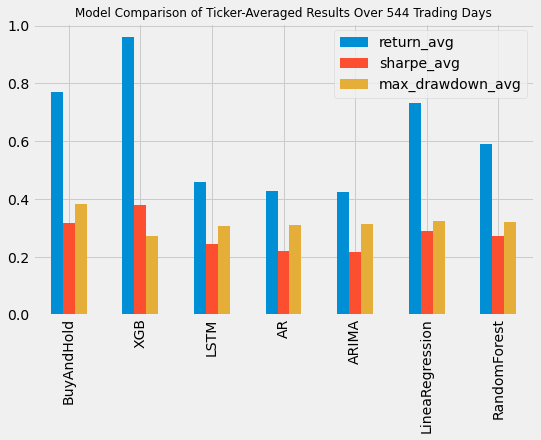

In [11]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(8,5))
ax.set_title('Model Comparison of Ticker-Averaged Results Over 544 Trading Days', fontsize=12)
avg_per_model_df.plot(kind='bar', ax=ax)

#### Returns per ticker per strategy

In [12]:
return_per_ticker_df = pd.DataFrame(xgb_backtesting_dict)
return_per_ticker_df = return_per_ticker_df.append(pd.DataFrame(lstm_results_full).loc['BasicStrategy', :])

In [13]:
for model in baseline_results_avg.keys():
    return_per_ticker_df = return_per_ticker_df.append(pd.DataFrame(baseline_results_full[model]).loc['BasicStrategy', :])

In [14]:
return_per_ticker_df.index = ['BuyAndHold', 'XGB', 'LSTM', 'AR', 'ARIMA', 'LineaRegression', 'RandomForest']

In [15]:
# this holds all results per ticker per model in a dataframe, we just want returns for now
total_result_df = return_per_ticker_df.copy()
total_result_df

,ADSK,HD,MSFT,UNH,WAT,XOM
BuyAndHold,"{'total_return': 1.172688052368164, 'monthly_s...","{'total_return': 0.5937408105468751, 'monthly_...","{'total_return': 1.460218879699707, 'monthly_s...","{'total_return': 0.984769447631836, 'monthly_s...","{'total_return': 0.5100885263061523, 'monthly_...","{'total_return': -0.10967397933959977, 'monthl..."
XGB,"{'total_return': 1.7682989747719402, 'monthly_...","{'total_return': 0.8711795697894968, 'monthly_...","{'total_return': 1.5005937375577245, 'monthly_...","{'total_return': 0.7940578541494352, 'monthly_...","{'total_return': 0.5751404745750697, 'monthly_...","{'total_return': 0.2567188505204112, 'monthly_..."
LSTM,"{'total_return': 0.4391497591734437, 'monthly_...","{'total_return': 0.31746595894940843, 'monthly...","{'total_return': 0.5632267601253933, 'monthly_...","{'total_return': 0.8997665993945383, 'monthly_...","{'total_return': 0.3826101356890981, 'monthly_...","{'total_return': 0.1547427296022419, 'monthly_..."
AR,"{'total_return': 0.3916002624187249, 'monthly_...","{'total_return': 0.29644045889668047, 'monthly...","{'total_return': 0.5950237969433196, 'monthly_...","{'total_return': 1.063427753461725, 'monthly_s...","{'total_return': 0.13919644080396165, 'monthly...","{'total_return': 0.08861447623460728, 'monthly..."
ARIMA,"{'total_return': 0.3916153139531233, 'monthly_...","{'total_return': 0.2906069842226535, 'monthly_...","{'total_return': 0.6030013601585884, 'monthly_...","{'total_return': 1.063427753461725, 'monthly_s...","{'total_return': 0.10907684539085594, 'monthly...","{'total_return': 0.08719356628214481, 'monthly..."
LineaRegression,"{'total_return': 0.8714367460695336, 'monthly_...","{'total_return': 0.30405429316906574, 'monthly...","{'total_return': 1.8732154255373432, 'monthly_...","{'total_return': 0.7750981967462371, 'monthly_...","{'total_return': 0.5652385531121671, 'monthly_...","{'total_return': 0.001937659451604512, 'monthl..."
RandomForest,"{'total_return': 0.5344284820314207, 'monthly_...","{'total_return': 0.7808338585324088, 'monthly_...","{'total_return': 0.7583759416460178, 'monthly_...","{'total_return': 1.0935754120157188, 'monthly_...","{'total_return': 0.2666686936547171, 'monthly_...","{'total_return': 0.11129980897109859, 'monthly..."


In [16]:
for idx in  return_per_ticker_df.index:
    for column in  return_per_ticker_df.columns:
         return_per_ticker_df.loc[idx, column] = return_per_ticker_df.loc[idx, column]['total_return']

In [17]:
return_per_ticker_df = return_per_ticker_df.apply(lambda x: x*100, axis=0)

<AxesSubplot:title={'center':'Model Comparison of Total Returns Over 544 Trading Days'}, ylabel='% Return from $100k Starting Cash'>

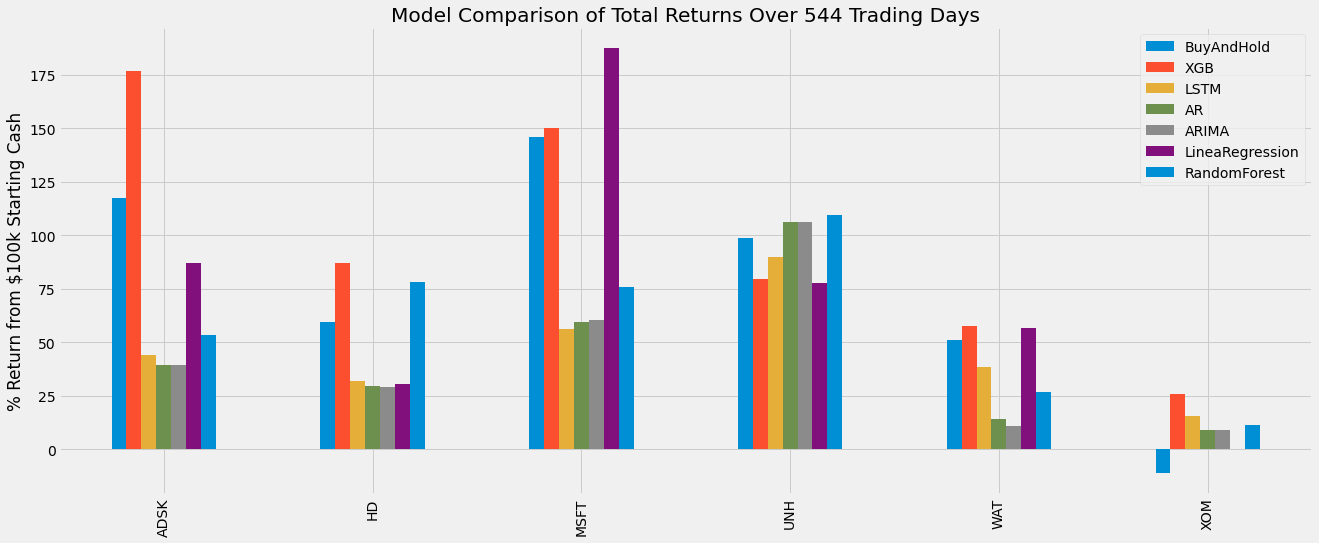

In [18]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(20,8))
ax.set_ylabel('% Return from $100k Starting Cash')
ax.set_title('Model Comparison of Total Returns Over 544 Trading Days')
return_per_ticker_df.swapaxes("index", "columns").plot(y=list(return_per_ticker_df.index), kind='bar', ax=ax)

### Library additionally has plotting
Documentation talks about keeping statistics at the bottom
https://www.backtrader.com/docu/observers-and-statistics/observers-and-statistics/

#### Plot XGBoost vs LSTM vs Linear Regression trading for ADSK

In [19]:
plt.style.use('default')

<IPython.core.display.Javascript object>


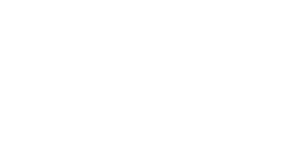

[[<Figure size 640x480 with 4 Axes>]]

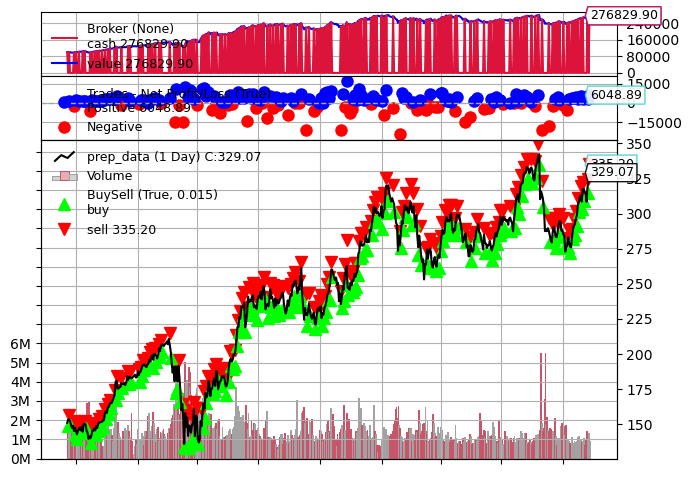

In [20]:
xgb_backtesting_dict['ADSK']['BasicStrategy']['cerebro_object'].plot()

<IPython.core.display.Javascript object>


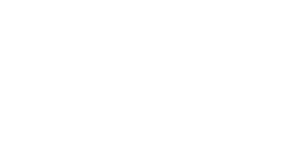

[[<Figure size 640x480 with 4 Axes>]]

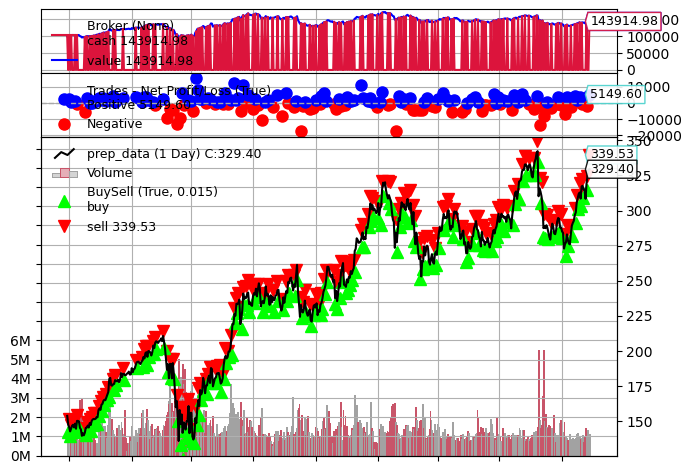

In [21]:
# plt.rcParams['figure.figsize'] = [10, 8]
# plt.rcParams.update({'font.size': 12})
lstm_results_full['ADSK']['BasicStrategy']['cerebro_object'].plot()

<IPython.core.display.Javascript object>


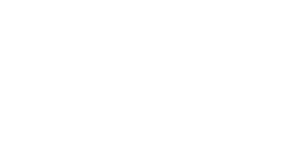

[[<Figure size 640x480 with 4 Axes>]]

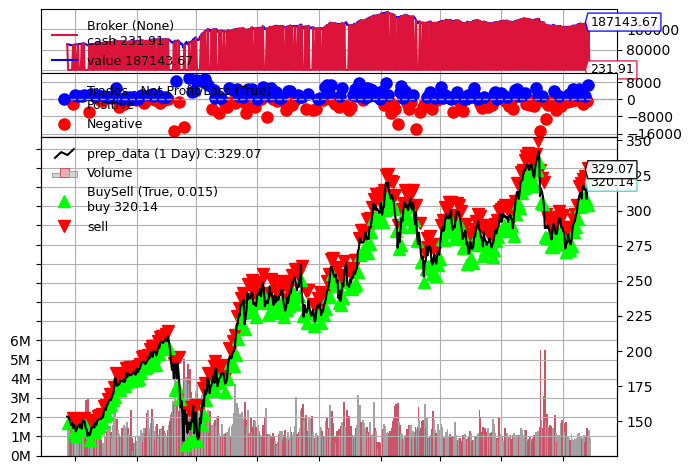

In [22]:
baseline_results_full['linreg_preds']['ADSK']['BasicStrategy']['cerebro_object'].plot()

### Ways to Improve:

Increase strategy trading volume. There are certain periods where sell orders are not going through for multiple days in a row, meaning that the price is lower than anticipated by model for that period. For example, if the last sell order didn't go through, we can find a way to use that information to inform our next sell order and make the prediction lower or try a market sell. Maybe train a "bear" model, one that only knows pain and suffering of bear markets, and only produces pessimistic high price predictions.   

Smarter entry points. Currently, buy orders are being executed at market price at the open (getting in position ASAP when not in a position). Returns may increase if entry constraints are increased.  

Resizing orders. Orders for this strategy baseline are currently 100% in or 100% out of position. This has beneifits if you want less exposure to the long term movement of the stocks. Depending on the situation and strategy, we might want to reserve a cash position to expose ourselves less to short term movements. 

Model ensembling. Models with similar R^2 scores on the test data can be ensembled together to create better prediction results.